*Link Vídeo*

## Importing Necessary Packages

In [884]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import pickle
import sklearn

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.calibration import CalibratedClassifierCV, calibration_curve

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

# Questão 1 - Predição de Pagamento de Empréstimos


## Briefing

* Base de dados já separada entre Treino e Teste, com 1500 linhas de Treino e 577 linhas de Teste.
* São 12 atributos, sendo 7 numéricos e 5 categóricos.

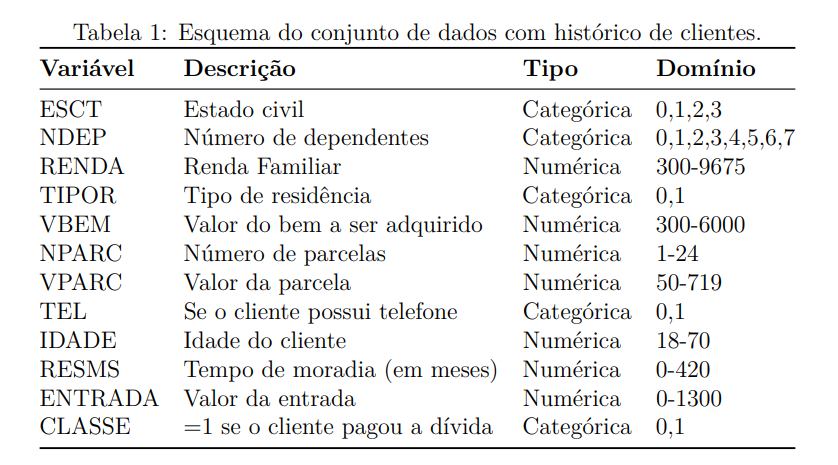

## Creating the DataFrame

In [454]:
# Nomeando as colunas
nomes_colunas = ['ESCT', 'NDEP', 'RENDA', 'TIPOR', 'VBEM', 'NPARC', 'VPARC', 'TEL', 'IDADE', 'RESMS', 'ENTRADA', 'CLASSE']

# Ajustando os dados de treino e de teste
data_train = pd.read_csv('./data/credtrain.txt', sep = '\t', header = None, names = nomes_colunas)
data_test = pd.read_csv('./data/credtest.txt', sep = '\t', header = None, names = nomes_colunas)

In [455]:
# Testando o tamanho do DataFrame
print(data_train.shape, data_test.shape)

(1500, 12) (577, 12)


In [456]:
# Testando se tem Nulos
data_train.isnull().sum().sum(), data_test.isnull().sum().sum()

(0, 0)

In [457]:
#Visualizando melhor os dados de Treino
data_train.describe()

,ESCT,NDEP,RENDA,TIPOR,VBEM,NPARC,VPARC,TEL,IDADE,RESMS,ENTRADA,CLASSE
count,1500.000000,1500.000000,1500.00000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000
mean,0.512000,0.126667,984.51200,0.445333,562.031333,8.392667,102.247333,0.134000,41.210667,31.528667,32.255333,0.476667
std,0.659909,0.572865,905.53292,0.497168,265.690646,3.609131,62.987325,0.340766,13.202266,52.662099,94.307614,0.499622
min,0.000000,0.000000,300.00000,0.000000,300.000000,1.000000,50.000000,0.000000,19.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,467.50000,0.000000,410.000000,6.000000,66.000000,0.000000,31.000000,6.000000,0.000000,0.000000
50%,0.000000,0.000000,650.00000,0.000000,490.000000,10.000000,83.000000,0.000000,39.000000,6.000000,0.000000,0.000000
75%,1.000000,0.000000,1200.00000,1.000000,618.000000,10.000000,118.000000,0.000000,52.000000,48.000000,0.000000,1.000000
max,3.000000,7.000000,8000.00000,1.000000,4000.000000,24.000000,711.000000,1.000000,70.000000,420.000000,1300.000000,1.000000


In [458]:
# Checando se as classes estão balanceadas no Treino

class_division = [ data_train[data_train['CLASSE'] == 1 ].shape[0], data_train[data_train['CLASSE'] == 0 ].shape[0] ]
my_labels = ['Pagantes', 'Não Pagantes']

print("Proporção de Pagantes: " + str(round(data_train[data_train['CLASSE'] == 1 ].shape[0]/data_train.shape[0] * 100, 2)) + "%")

Proporção de Pagantes: 47.67%


In [459]:
# Checando se as classes estão balanceadas no Teste

class_division = [ data_test[data_test['CLASSE'] == 1 ].shape[0], data_test[data_test['CLASSE'] == 0 ].shape[0] ]
my_labels = ['Pagantes', 'Não Pagantes']

print("Proporção de Pagantes: " + str(round(data_test[data_test['CLASSE'] == 1 ].shape[0]/data_test.shape[0] * 100, 2)) + "%")

Proporção de Pagantes: 46.97%


## Data Processing

Como existem atributos categóricos e numéricos, é necessário tratar os atributos categóricos antes de rodar o modelo. No caso do dataset, a maioria dos atributos categóricos variam entre 0 e 1, com exceção de 'ESCT' e 'NDEP'. 'NDEP' representa o número de dependentes, tendo uma noção de ordem/grandeza. 'ESCT', no entanto, varia de 0 a 3, mas não apresenta a mesma relação. Por isso, vamos transformar a coluna 'ESCT' em variáveis dummy.

In [460]:
# Aplicando one-hot-encoding
data_train = pd.get_dummies(data_train, columns = ['ESCT'])
data_test = pd.get_dummies(data_test, columns = ['ESCT']) 

In [461]:
# Separando variáveis categóricas das variáveis numéricas

num = ['RENDA', 'VBEM', 'NPARC', 'VPARC', 'IDADE', 'RESMS', 'ENTRADA']
cat = ['ESCT_0', 'ESCT_1', 'ESCT_2', 'ESCT_3', 'NDEP', 'TIPOR', 'TEL']

# Aplicando a separação nos conjuntos de treino e teste

X_train_num = data_train[num]
X_train_cat = data_train[cat] # Já está com One-Hot-Encoding 
y_train = data_train['CLASSE'] # Definindo CLASSE como o y do treino

X_test_num = data_test[num]
X_test_cat = data_test[cat] # Já está com One-Hot-Encoding 
y_test = data_test['CLASSE'] # Definindo CLASSE como o y do teste

In [462]:
# Normalizando os dados

scaler = StandardScaler()
X_train_num_normalized = scaler.fit_transform(X_train_num)
X_test_num_normalized = scaler.transform(X_test_num)

In [463]:
# Concatenando as variáveis

X_train = np.concatenate((X_train_num_normalized, X_train_cat), axis=1)
X_test = np.concatenate((X_test_num_normalized, X_test_cat), axis=1)

## Building the Models

In [464]:
# Listando os modelos

LR = LogisticRegression()
LR.fit(X_train, y_train)

DT = DecisionTreeClassifier()
DT.fit(X_train, y_train)

RF = RandomForestClassifier()
RF.fit(X_train, y_train)

KNN = KNeighborsClassifier()
KNN.fit(X_train, y_train)

GB = GradientBoostingClassifier()
GB.fit(X_train, y_train)


GradientBoostingClassifier()

*Logistic Regression*


Logistic Regression - Resultados


Relatório de Classificação

              precision    recall  f1-score   support

           0       0.86      0.95      0.90       306
           1       0.93      0.82      0.87       271

    accuracy                           0.89       577
   macro avg       0.90      0.89      0.89       577
weighted avg       0.89      0.89      0.89       577


Matriz de Confusão



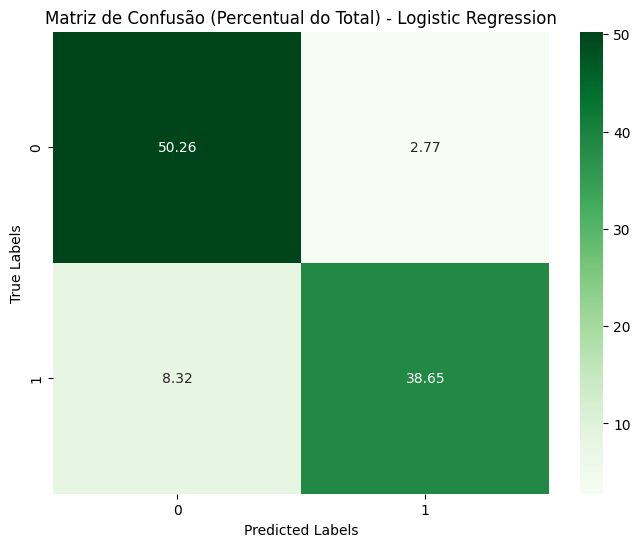

In [465]:
# Logistic Regression

y_pred_lr = LR.predict(X_test)
matriz_confusao_lr = confusion_matrix(y_test, y_pred_lr)

# Calculando a matriz de confusão por percentuais
total_amostras = len(y_test)
matriz_percentual_lr = (matriz_confusao_lr / total_amostras) * 100  # Dividindo pelo total e multiplicando por 100

# Resultados

print('\nLogistic Regression - Resultados\n')
print('\nRelatório de Classificação\n')
print(classification_report(y_test, y_pred_lr))
print('\nMatriz de Confusão\n')

# Plotar a matriz de confusão como percentuais usando seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(matriz_percentual_lr, annot = True, fmt = '.2f', cmap = 'Greens')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Matriz de Confusão (Percentual do Total) - Logistic Regression')
plt.show()

*Decision Tree*


Decision Tree - Resultados


Relatório de Classificação

              precision    recall  f1-score   support

           0       0.88      0.85      0.87       306
           1       0.84      0.87      0.85       271

    accuracy                           0.86       577
   macro avg       0.86      0.86      0.86       577
weighted avg       0.86      0.86      0.86       577


Matriz de Confusão



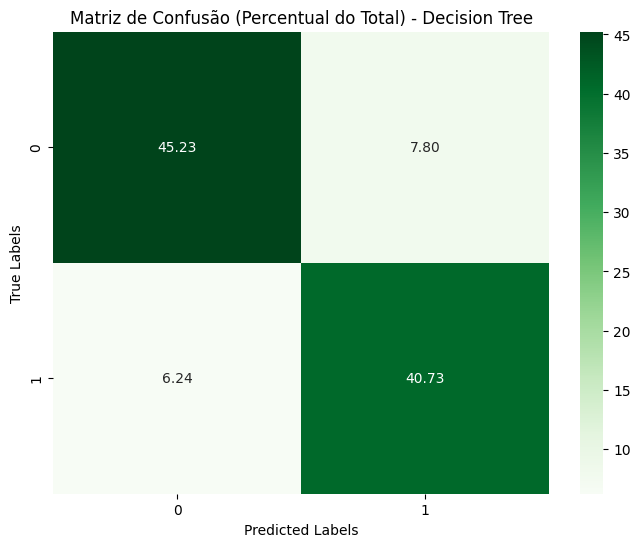

In [466]:
# Decision Tree

y_pred_dt = DT.predict(X_test)
matriz_confusao_dt = confusion_matrix(y_test, y_pred_dt)

# Calculando a matriz de confusão por percentuais
total_amostras = len(y_test)
matriz_percentual_dt = (matriz_confusao_dt / total_amostras) * 100  # Dividindo pelo total e multiplicando por 100

# Resultados

print('\nDecision Tree - Resultados\n')
print('\nRelatório de Classificação\n')
print(classification_report(y_test, y_pred_dt))
print('\nMatriz de Confusão\n')

# Plotar a matriz de confusão como percentuais usando seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(matriz_percentual_dt, annot = True, fmt = '.2f', cmap = 'Greens')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Matriz de Confusão (Percentual do Total) - Decision Tree')
plt.show()

*Random Forest*


Random Forest - Resultados


Relatório de Classificação

              precision    recall  f1-score   support

           0       0.86      0.96      0.91       306
           1       0.95      0.83      0.88       271

    accuracy                           0.90       577
   macro avg       0.91      0.89      0.90       577
weighted avg       0.90      0.90      0.90       577


Matriz de Confusão



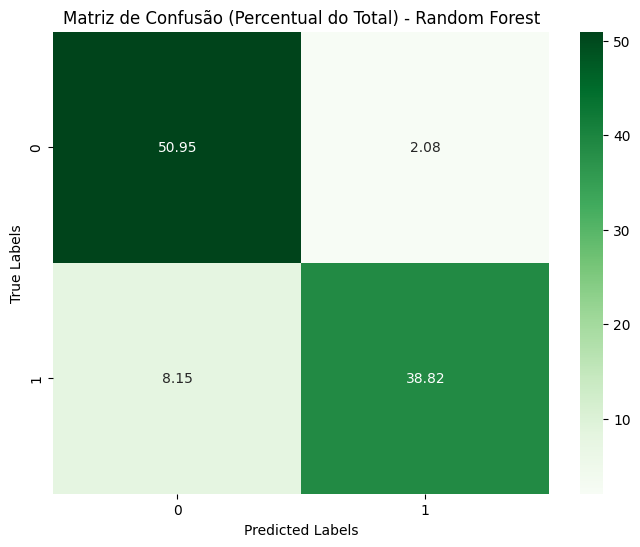

In [467]:
# Random Forest

y_pred_rf = RF.predict(X_test)
matriz_confusao_rf = confusion_matrix(y_test, y_pred_rf)

# Calculando a matriz de confusão por percentuais
total_amostras = len(y_test)
matriz_percentual_rf = (matriz_confusao_rf / total_amostras) * 100  # Dividindo pelo total e multiplicando por 100

# Resultados

print('\nRandom Forest - Resultados\n')
print('\nRelatório de Classificação\n')
print(classification_report(y_test, y_pred_rf))
print('\nMatriz de Confusão\n')

# Plotar a matriz de confusão como percentuais usando seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(matriz_percentual_rf, annot = True, fmt = '.2f', cmap = 'Greens')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Matriz de Confusão (Percentual do Total) - Random Forest')
plt.show()

*KNN*


KNN - Resultados


Relatório de Classificação

              precision    recall  f1-score   support

           0       0.83      0.92      0.87       306
           1       0.90      0.79      0.84       271

    accuracy                           0.86       577
   macro avg       0.86      0.86      0.86       577
weighted avg       0.86      0.86      0.86       577


Matriz de Confusão



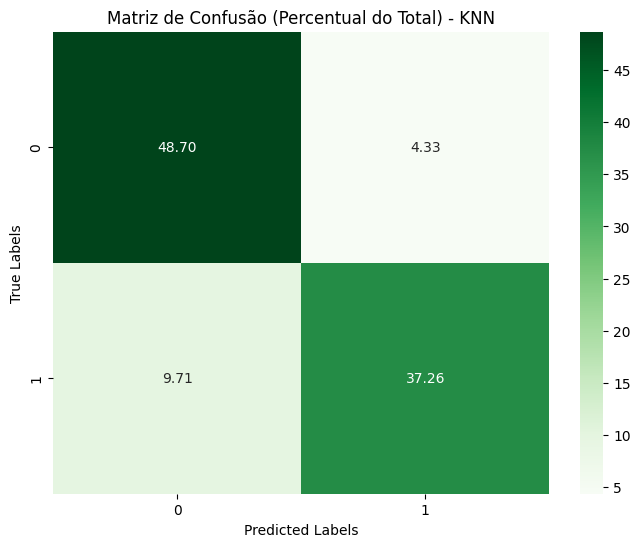

In [468]:
# KNN

y_pred_knn = KNN.predict(X_test)
matriz_confusao_knn = confusion_matrix(y_test, y_pred_knn)

# Calculando a matriz de confusão por percentuais
total_amostras = len(y_test)
matriz_percentual_knn = (matriz_confusao_knn / total_amostras) * 100  # Dividindo pelo total e multiplicando por 100

# Resultados

print('\nKNN - Resultados\n')
print('\nRelatório de Classificação\n')
print(classification_report(y_test, y_pred_knn))
print('\nMatriz de Confusão\n')

# Plotar a matriz de confusão como percentuais usando seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(matriz_percentual_knn, annot = True, fmt = '.2f', cmap = 'Greens')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Matriz de Confusão (Percentual do Total) - KNN')
plt.show()

*Gradient Boosting*


Gradient Boost - Resultados


Relatório de Classificação

              precision    recall  f1-score   support

           0       0.86      0.97      0.91       306
           1       0.96      0.83      0.89       271

    accuracy                           0.90       577
   macro avg       0.91      0.90      0.90       577
weighted avg       0.91      0.90      0.90       577


Matriz de Confusão



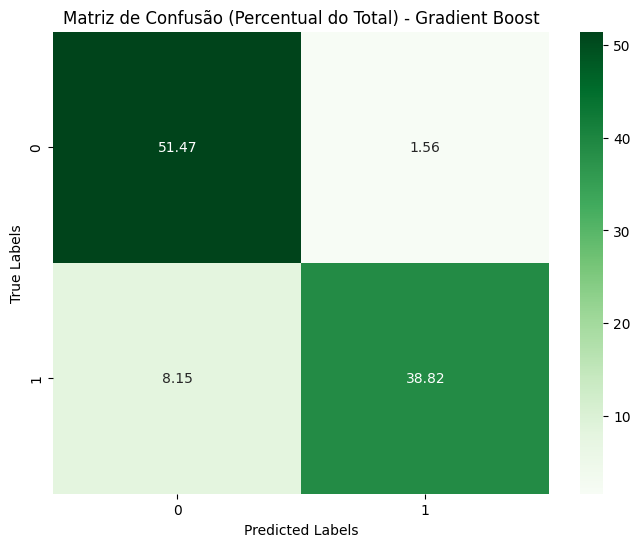

In [469]:
# Gradient Boosting

y_pred_gb = GB.predict(X_test)
matriz_confusao_gb = confusion_matrix(y_test, y_pred_gb)

# Calculando a matriz de confusão por percentuais
total_amostras = len(y_test)
matriz_percentual_gb = (matriz_confusao_gb / total_amostras) * 100  # Dividindo pelo total e multiplicando por 100

# Resultados

print('\nGradient Boost - Resultados\n')
print('\nRelatório de Classificação\n')
print(classification_report(y_test, y_pred_gb))
print('\nMatriz de Confusão\n')

# Plotar a matriz de confusão como percentuais usando seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(matriz_percentual_gb, annot = True, fmt = '.2f', cmap = 'Greens')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Matriz de Confusão (Percentual do Total) - Gradient Boost')
plt.show()

## Final Results

In [470]:
def results_metrics():
    return {'Model': [], 'Accuracy': [], 'Precision': [], 'Recall': [], 'F1_score': []}

In [471]:
def add_results(y_test=None, y_pred=None, label='', df=None):
    df['Model'].append(label)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    df['Accuracy'].append(accuracy)
    df['Precision'].append(precision)
    df['Recall'].append(recall)
    df['F1_score'].append(f1)
    
    print(f'Confusion Matrix: \n {confusion_matrix(y_test, y_pred)}') 

In [472]:
final_results = results_metrics()

# Logistic Regression
add_results(y_test = y_test,
            y_pred = y_pred_lr, 
            label = 'Logistic Regression', 
            df = final_results)

# Decision Tree
add_results(y_test = y_test,
            y_pred = y_pred_dt, 
            label = 'Decision Tree', 
            df = final_results)

# Random Forest
add_results(y_test = y_test,
            y_pred = y_pred_rf, 
            label = 'Random Forest', 
            df = final_results)

# KNN
add_results(y_test = y_test,
            y_pred = y_pred_knn, 
            label = 'KNN', 
            df = final_results)

# Gradient Boost
add_results(y_test = y_test,
            y_pred = y_pred_gb, 
            label = 'Gradient Boost', 
            df = final_results)


Confusion Matrix: 
 [[290  16]
 [ 48 223]]
Confusion Matrix: 
 [[261  45]
 [ 36 235]]
Confusion Matrix: 
 [[294  12]
 [ 47 224]]
Confusion Matrix: 
 [[281  25]
 [ 56 215]]
Confusion Matrix: 
 [[297   9]
 [ 47 224]]


In [591]:
pd.DataFrame(final_results)

,Model,Accuracy,Precision,Recall,F1_score
0,Logistic Regression,0.889081,0.933054,0.822878,0.874510
1,Decision Tree,0.859619,0.839286,0.867159,0.852995
2,Random Forest,0.897747,0.949153,0.826568,0.883629
3,KNN,0.859619,0.895833,0.793358,0.841487
4,Gradient Boost,0.902946,0.961373,0.826568,0.888889


# Questão 2 - Predição de Preço de Diamantes ##

## Briefing

Base de dados extraída de: https://www.kaggle.com/datasets/shivam2503/diamonds

**Context**
* This classic dataset contains the prices and other attributes of almost 54,000 diamonds. It's a great dataset for beginners learning to work with data analysis and visualization.

**Content**
* **price** price in US dollars (\$326--\$18,823)
* **carat** weight of the diamond (0.2--5.01)
* **cut** quality of the cut (Fair, Good, Very Good, Premium, Ideal)
* **color** diamond colour, from J (worst) to D (best)
* **clarity** a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))
* **x length** in mm (0--10.74)
* **y width** in mm (0--58.9)
* **z depth** in mm (0--31.8)
* **depth** total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43--79)
* **table** width of top of diamond relative to widest point (43--95)

## Creating the DataFrame

In [473]:
data = pd.read_csv('diamonds.csv')
data.head(10)

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
5,6,0.24,Very Good,J,VVS2,62.8,57.0,336,3.94,3.96,2.48
6,7,0.24,Very Good,I,VVS1,62.3,57.0,336,3.95,3.98,2.47
7,8,0.26,Very Good,H,SI1,61.9,55.0,337,4.07,4.11,2.53
8,9,0.22,Fair,E,VS2,65.1,61.0,337,3.87,3.78,2.49
9,10,0.23,Very Good,H,VS1,59.4,61.0,338,4.00,4.05,2.39


In [474]:
data = data.drop(columns= ['Unnamed: 0']) # Excluindo a coluna "Unnamed"
data

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...
53935,0.72,Ideal,D,SI1,60.8,57.0,2757,5.75,5.76,3.50
53936,0.72,Good,D,SI1,63.1,55.0,2757,5.69,5.75,3.61
53937,0.70,Very Good,D,SI1,62.8,60.0,2757,5.66,5.68,3.56
53938,0.86,Premium,H,SI2,61.0,58.0,2757,6.15,6.12,3.74


In [475]:
# Testando se tem Nulos
data.isnull().sum().sum()

0

In [476]:
#Visualizando melhor os dados
data.describe()

,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


## Data Processing

*Dados Categóricos*

In [477]:
# Analisando os valores categóricos

print(data['cut'].unique())
print(data['color'].unique())
print(data['clarity'].unique())

['Ideal' 'Premium' 'Good' 'Very Good' 'Fair']
['E' 'I' 'J' 'H' 'F' 'G' 'D']
['SI2' 'SI1' 'VS1' 'VS2' 'VVS2' 'VVS1' 'I1' 'IF']


In [478]:
# Transformando os valores categóricos em ordem do melhor pro pior

cut_mapping = {
    'Ideal': 4,
    'Premium': 3,
    'Very Good': 2,
    'Good': 1,
    'Fair': 0
}

color_mapping = {
    'D': 6,
    'E': 5,
    'F': 4,
    'G': 3,
    'H': 2,
    'I': 1,
    'J': 0                
}

clarity_mapping = {
    'IF': 7,
    'VVS1': 6,
    'VVS2': 5,
    'VS1': 4,
    'VS2': 3,
    'SI1': 2,
    'SI2': 1,
    'I1': 0
}


data['cut'] = data['cut'].map(cut_mapping)
data['color'] = data['color'].map(color_mapping)
data['clarity'] = data['clarity'].map(clarity_mapping)

In [479]:
# Checando se os atributos foram atualizados
data.sample(5)

,carat,cut,color,clarity,depth,table,price,x,y,z
27927,0.38,3,5,2,58.1,58.0,658,4.85,4.79,2.80
3364,0.30,2,1,3,60.7,56.0,407,4.32,4.34,2.63
13137,1.07,4,4,2,59.4,57.0,5436,6.73,6.67,3.98
25328,1.51,2,3,4,59.5,59.0,14028,7.41,7.45,4.42
41993,0.43,4,3,6,62.0,55.0,1264,4.85,4.82,3.00


*Separando Treino e Teste*

In [480]:
# Separando dados entre treino e teste

X = data.drop(columns= ['price']) # Coluna price excluída do treino
y = data['price'] # Definindo price como nosso y

X.columns = ['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'x', 'y', 'z']

X_train, X_test, y_train, y_test = train_test_split (X, y, test_size = 0.2)

# Dividindo na proporção 80/20 treino/teste.

*Normalizando os Dados*

In [481]:
# Normalizando os dados

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Building the Models

In [482]:
# Listando os modelos

LR = LinearRegression()
LR.fit(X_train, y_train)

LA = Lasso()
LA.fit(X_train, y_train)

DT = DecisionTreeRegressor()
DT.fit(X_train, y_train)

RF = RandomForestRegressor()
RF.fit(X_train, y_train)

KNN = KNeighborsRegressor()
KNN.fit(X_train, y_train)

GB = GradientBoostingRegressor()
GB.fit(X_train, y_train)

GradientBoostingRegressor()

*Linear Regression*

In [483]:
# Rodando o modelo
y_pred_LR = LR.predict(X_test)

# Calculando o MSE
mse_LR = mean_squared_error(y_test, y_pred_LR)

# Calculando o R²
r2_LR = r2_score(y_test, y_pred_LR)

# Mostrando os resultados
print('MSE e R² para Linear Regression: MSE = {:.2f}, R² = {:.4f}'.format(mse_LR, r2_LR))

MSE e R² para Linear Regression: MSE = 1505047.01, R² = 0.9044


*Lasso*

In [484]:
# Rodando o modelo
y_pred_LA = LA.predict(X_test)

# Calculando o MSE
mse_LA = mean_squared_error(y_test, y_pred_LA)

# Calculando o R²
r2_LA = r2_score(y_test, y_pred_LA)

# Mostrando os resultados
print('MSE e R² para Lasso: MSE = {:.2f}, R² = {:.4f}'.format(mse_LA, r2_LA))

MSE e R² para Lasso: MSE = 1504360.57, R² = 0.9045


*Decision Tree*

In [485]:
# Rodando o modelo
y_pred_DT = DT.predict(X_test)

# Calculando o MSE
mse_DT = mean_squared_error(y_test, y_pred_DT)

# Calculando o R²
r2_DT = r2_score(y_test, y_pred_DT)

# Mostrando os resultados
print('MSE e R² para Decision Tree: MSE = {:.2f}, R² = {:.4f}'.format(mse_DT, r2_DT))

MSE e R² para Decision Tree: MSE = 518935.90, R² = 0.9671


*Random Forest*

In [486]:
# Rodando o modelo
y_pred_RF = RF.predict(X_test)

# Calculando o MSE
mse_RF = mean_squared_error(y_test, y_pred_RF)

# Calculando o R²
r2_RF = r2_score(y_test, y_pred_RF)

# Mostrando os resultados
print('MSE e R² para Random Forest: MSE = {:.2f}, R² = {:.4f}'.format(mse_RF, r2_RF))

MSE e R² para Random Forest: MSE = 286867.81, R² = 0.9818


*KNN*

In [487]:
# Rodando o modelo
y_pred_KNN = KNN.predict(X_test)

# Calculando o MSE
mse_KNN = mean_squared_error(y_test, y_pred_KNN)

# Calculando o R²
r2_KNN = r2_score(y_test, y_pred_KNN)

# Mostrando os resultados
print('MSE e R² para KNeighbors: MSE = {:.2f}, R² = {:.4f}'.format(mse_KNN, r2_KNN))

MSE e R² para KNeighbors: MSE = 527132.42, R² = 0.9665


*Gradient Boosting*

In [488]:
# Rodando o modelo
y_pred_GB = GB.predict(X_test)

# Calculando o MSE
mse_GB = mean_squared_error(y_test, y_pred_GB)

# Calculando o R²
r2_GB = r2_score(y_test, y_pred_GB)

# Mostrando os resultados
print('MSE e R² para Gradient Boosting: MSE = {:.2f}, R² = {:.4f}'.format(mse_GB, r2_GB))

MSE e R² para Gradient Boosting: MSE = 383025.20, R² = 0.9757


## Final Results

In [489]:
# Comparando os resultados

resultados = {
    'Modelo': ['Linear Regression', 'Lasso', 'Decision Tree', 'Random Forest', 'KNN', 'Gradient Boosting'],
    'MSE': [mse_LR, mse_LA, mse_DT, mse_RF, mse_KNN, mse_GB],
    'R²': [r2_LR, r2_LA, r2_DT, r2_RF, r2_KNN, r2_GB]
}

# Arredondando os valores para 4 casas decimais
for key in resultados.keys():
    if key != 'Modelo':
        resultados[key] = [round(value, 3) for value in resultados[key]]

# Criando um DataFrame de resultados
df_resultados = pd.DataFrame(resultados)
print(df_resultados)

              Modelo          MSE     R²
0  Linear Regression  1505047.011  0.904
1              Lasso  1504360.571  0.904
2      Decision Tree   518935.903  0.967
3      Random Forest   286867.813  0.982
4                KNN   527132.418  0.967
5  Gradient Boosting   383025.198  0.976


# Questão 3 - Desbalanceamento de Bases

## Briefing

* 5 arquivos no formato Pickle: A602.pickle, A621.pickle, A627.pickle, A636.pickle, A652.pickle;
* Cada um desses arquivos contém conjuntos de treino, validação e testes;
* São dados de problema de classificação binária altamente desbalanceados;
* Na matriz y_* é necessário transformar os dados em binários: tudo que for diferente de 0 deve virar 1;
* É preciso usar o Gradient Boosting Classifier (e não o Regressor).

In [490]:
'''import numpy as np
import pickle
file = open(outfilename , 'rb')
(X_train , y_train , X_val , y_val , X_test , y_test) = pickle.load(file)
print(f"Shapes: ", X_train.shape , X_val.shape , X_test.shape)'''

#  Nesse trecho de código, outfilename é o nome de um dos cinco arquivo fornecidos.

'import numpy as np\nimport pickle\nfile = open(outfilename , \'rb\')\n(X_train , y_train , X_val , y_val , X_test , y_test) = pickle.load(file)\nprint(f"Shapes: ", X_train.shape , X_val.shape , X_test.shape)'

## Creating the DataFrame

In [936]:
# A602.pickle ---> File 1

file_1 = open('.\data\A602.pickle', 'rb')
(X_train_1 , y_train_1 , X_val_1 , y_val_1 , X_test_1 , y_test_1) = pickle.load(file_1)

# Criando os DataFrames
df_X_train_1 = pd.DataFrame(X_train_1).astype(int)
df_y_train_1 = pd.DataFrame(y_train_1).astype(int)
df_X_val_1 = pd.DataFrame(X_val_1).astype(int)
df_y_val_1 = pd.DataFrame(y_val_1).astype(int)
df_X_test_1 = pd.DataFrame(X_test_1).astype(int)
df_y_test_1 = pd.DataFrame(y_test_1).astype(int)

print(f'Shapes: ', df_X_train_1.shape , df_X_val_1.shape , df_X_test_1.shape)

Shapes:  (10178, 24) (2565, 24) (765, 24)


In [937]:
# A621.pickle ---> File 2

file_2 = open('.\data\A621.pickle', 'rb')
(X_train_2 , y_train_2 , X_val_2 , y_val_2 , X_test_2 , y_test_2) = pickle.load(file_2)

# Criando os DataFrames
df_X_train_2 = pd.DataFrame(X_train_2).astype(int)
df_y_train_2 = pd.DataFrame(y_train_2).astype(int)
df_X_val_2 = pd.DataFrame(X_val_2).astype(int)
df_y_val_2 = pd.DataFrame(y_val_2).astype(int)
df_X_test_2 = pd.DataFrame(X_test_2).astype(int)
df_y_test_2 = pd.DataFrame(y_test_2).astype(int)

print(f'Shapes: ', df_X_train_2.shape , df_X_val_2.shape , df_X_test_2.shape)

Shapes:  (9549, 24) (2428, 24) (10080, 24)


In [939]:
# A627.pickle ---> File 3

file_3 = open('.\data\A627.pickle', 'rb')
(X_train_3 , y_train_3 , X_val_3 , y_val_3 , X_test_3 , y_test_3) = pickle.load(file_3)

# Criando os DataFrames
df_X_train_3 = pd.DataFrame(X_train_3).astype(int)
df_y_train_3 = pd.DataFrame(y_train_3).astype(int)
df_X_val_3 = pd.DataFrame(X_val_3).astype(int)
df_y_val_3 = pd.DataFrame(y_val_3).astype(int)
df_X_test_3 = pd.DataFrame(X_test_3).astype(int)
df_y_test_3 = pd.DataFrame(y_test_3).astype(int)

print(f'Shapes: ', df_X_train_3.shape , df_X_val_3.shape , df_X_test_3.shape)

Shapes:  (9682, 24) (2235, 24) (10202, 24)


In [940]:
# A636.pickle ---> File 4

file_4 = open('.\data\A636.pickle', 'rb')
(X_train_4 , y_train_4 , X_val_4 , y_val_4 , X_test_4 , y_test_4) = pickle.load(file_4)

# Criando os DataFrames
df_X_train_4 = pd.DataFrame(X_train_4).astype(int)
df_y_train_4 = pd.DataFrame(y_train_4).astype(int)
df_X_val_4 = pd.DataFrame(X_val_4).astype(int)
df_y_val_4 = pd.DataFrame(y_val_4).astype(int)
df_X_test_4 = pd.DataFrame(X_test_4).astype(int)
df_y_test_4 = pd.DataFrame(y_test_4).astype(int)

print(f'Shapes: ', df_X_train_4.shape , df_X_val_4.shape , df_X_test_4.shape)

Shapes:  (10219, 24) (2414, 24) (10129, 24)


In [941]:
# A652.pickle ---> 5

file_5 = open('.\data\A652.pickle', 'rb')
(X_train_5 , y_train_5 , X_val_5 , y_val_5 , X_test_5 , y_test_5) = pickle.load(file_5)

# Criando os DataFrames
df_X_train_5 = pd.DataFrame(X_train_5).astype(int)
df_y_train_5 = pd.DataFrame(y_train_5).astype(int)
df_X_val_5 = pd.DataFrame(X_val_5).astype(int)
df_y_val_5 = pd.DataFrame(y_val_5).astype(int)
df_X_test_5 = pd.DataFrame(X_test_5).astype(int)
df_y_test_5 = pd.DataFrame(y_test_5).astype(int)

print(f'Shapes: ', df_X_train_5.shape , df_X_val_5.shape , df_X_test_5.shape)

Shapes:  (10012, 24) (2506, 24) (9582, 24)


## Data Processing

*Dados Binários nas Matrizes Y*

In [942]:
# Lista de sufixos dos DataFrames
sufixos = [1, 2, 3, 4, 5]
sets = ['train', 'test', 'val']

def transform_to_binary(df):
    return df.applymap(lambda x: 1 if x > 0 else 0)

def to_int(df):
    return df.astype(int)

for set_name in sets:
    for sufixo in sufixos:
        nome_df = 'df_y_{}_{}'.format(set_name, sufixo)  # Montando o nome do DataFrame (sufixos)
        df = locals()[nome_df]
        df = transform_to_binary(df)  # Aplicando a função ao DataFrame
        df = to_int(df)  # Convertendo para inteiro
        locals()[nome_df] = df  # Atualizando o DataFrame original com os resultados

C:\Users\arau012\AppData\Local\Temp\1\ipykernel_11072\4097640748.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return df.applymap(lambda x: 1 if x > 0 else 0)
C:\Users\arau012\AppData\Local\Temp\1\ipykernel_11072\4097640748.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return df.applymap(lambda x: 1 if x > 0 else 0)
C:\Users\arau012\AppData\Local\Temp\1\ipykernel_11072\4097640748.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return df.applymap(lambda x: 1 if x > 0 else 0)
C:\Users\arau012\AppData\Local\Temp\1\ipykernel_11072\4097640748.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return df.applymap(lambda x: 1 if x > 0 else 0)
C:\Users\arau012\AppData\Local\Temp\1\ipykernel_11072\4097640748.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return df.applymap(lambda x: 1 if

In [943]:
# Mostrando que os dados se tornaram binários
df_y_train_2[0].value_counts()

0
0    9231
1     318
Name: count, dtype: int64

In [944]:
# Mostrando que os dados se tornaram binários
df_y_val_4[0].value_counts()

0
0    2300
1     114
Name: count, dtype: int64

In [945]:
# Mostrando que os dados se tornaram binários
df_y_test_1[0].value_counts()

0
0    720
1     45
Name: count, dtype: int64

*Checando o Balanceamento das Classes*

In [946]:
# Checando se as classes estão balanceadas

class_counts = df_y_test_1.value_counts()
print(class_counts)

# Para calcular a proporção de 1s em relação ao total
proporcao_classe_1 = class_counts[1] / len(df_y_test_1) * 100
print('Proporção de 1: {:.2f}%'.format(proporcao_classe_1))

0    720
1     45
Name: count, dtype: int64
Proporção de 1: 5.88%


*Criando Dicionário para Receber Resultados*

In [947]:
def results_metrics():
    return {'Model': [], 'Accuracy': [], 'Precision': [], 'Recall': [], 'F1_score': []}

In [948]:
def add_results(df_y_test=None, df_y_pred=None, label='', df=None):
    df['Model'].append(label)

    accuracy = accuracy_score(df_y_test, df_y_pred)
    precision = precision_score(df_y_test, df_y_pred)
    recall = recall_score(df_y_test, df_y_pred)
    f1 = f1_score(df_y_test, df_y_pred)

    df['Accuracy'].append(accuracy)
    df['Precision'].append(precision)
    df['Recall'].append(recall)
    df['F1_score'].append(f1)
    
    print(f'Confusion Matrix: \n {confusion_matrix(df_y_test, df_y_pred)}') 

## Building Models - Imbalanced

*Confusion Matrix + Relatório de Classificação*

In [949]:
# Calculando a matriz de confusão por percentuais + Relatório de Classificação
def matrix (df_y_test, y_pred):
    matriz_confusao = confusion_matrix(df_y_test, y_pred)
    total_amostras = len(df_y_test)
    matriz_percentual = (matriz_confusao / total_amostras) * 100  # Dividindo pelo total e multiplicando por 100
    print('\nGradient Boost - Resultados\n')
    print('\nRelatório de Classificação\n')
    print(classification_report(df_y_test, y_pred))
    print('\nMatriz de Confusão\n')
    plt.figure(figsize=(8, 6))
    sns.heatmap(matriz_percentual, annot = True, fmt = '.2f', cmap = 'Greens')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Matriz de Confusão (Percentual do Total) - Gradient Boost')
    plt.show()

*File 1*

C:\Users\arau012\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Gradient Boost - Resultados


Relatório de Classificação

              precision    recall  f1-score   support

           0       0.94      0.99      0.97       720
           1       0.33      0.04      0.08        45

    accuracy                           0.94       765
   macro avg       0.64      0.52      0.52       765
weighted avg       0.91      0.94      0.92       765


Matriz de Confusão



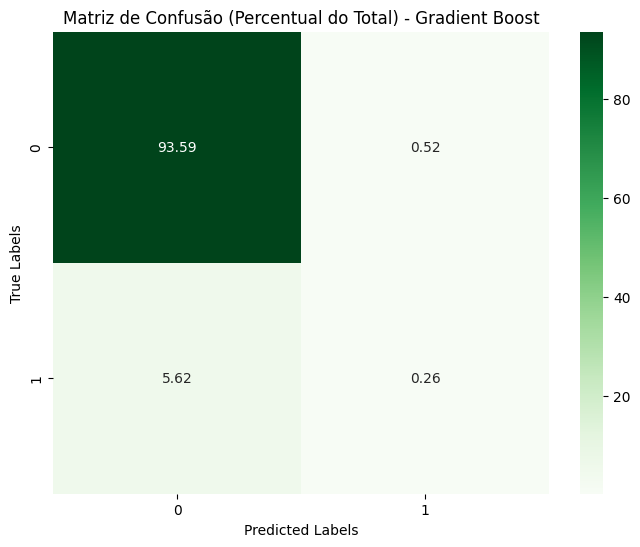

Confusion Matrix: 
 [[716   4]
 [ 43   2]]


In [950]:
# File 1 - Gradient Boosting Imbalanced

GB1 = GradientBoostingClassifier()
GB1.fit(df_X_train_1, df_y_train_1)

y_pred_gb1 = GB1.predict(df_X_test_1)

matrix(df_y_test_1,y_pred_gb1)

# Salvando os resultados no dicionário

results_1 = results_metrics()
add_results(
    df_y_test = df_y_test_1,
    df_y_pred = y_pred_gb1, 
    label = 'Imbalanced', 
    df = results_1
)

*File 2*

C:\Users\arau012\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Gradient Boost - Resultados


Relatório de Classificação

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      9699
           1       0.50      0.01      0.01       381

    accuracy                           0.96     10080
   macro avg       0.73      0.50      0.50     10080
weighted avg       0.94      0.96      0.94     10080


Matriz de Confusão



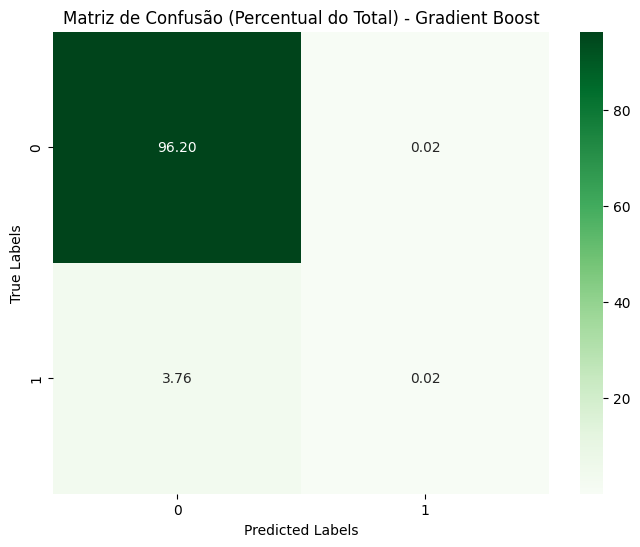

Confusion Matrix: 
 [[9697    2]
 [ 379    2]]


In [951]:
# File 2 - Gradient Boosting Imbalanced

GB2 = GradientBoostingClassifier()
GB2.fit(df_X_train_2, df_y_train_2)

y_pred_gb2 = GB2.predict(df_X_test_2)

matrix(df_y_test_2,y_pred_gb2)

# Salvando os resultados no dicionário

results_2 = results_metrics()
add_results(
    df_y_test = df_y_test_2,
    df_y_pred = y_pred_gb2, 
    label = 'Imbalanced', 
    df = results_2
)

*File 3*

C:\Users\arau012\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Gradient Boost - Resultados


Relatório de Classificação

              precision    recall  f1-score   support

           0       0.97      0.98      0.97      9849
           1       0.15      0.09      0.11       353

    accuracy                           0.95     10202
   macro avg       0.56      0.53      0.54     10202
weighted avg       0.94      0.95      0.94     10202


Matriz de Confusão



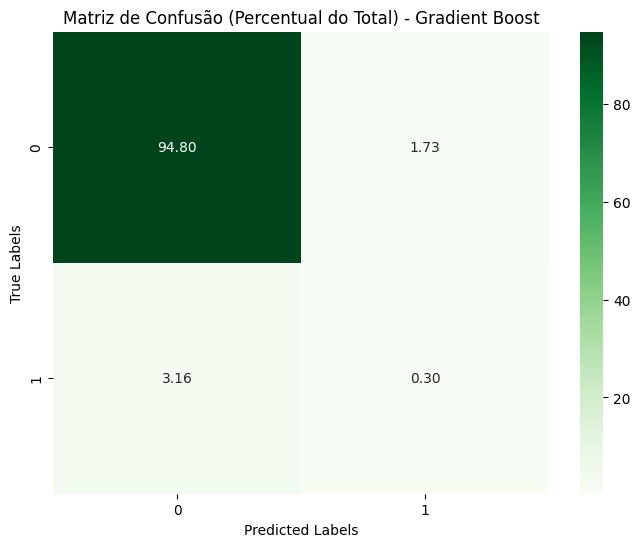

Confusion Matrix: 
 [[9672  177]
 [ 322   31]]


In [952]:
# File 3 - Gradient Boosting Imbalanced

GB3 = GradientBoostingClassifier()
GB3.fit(df_X_train_3, df_y_train_3)

y_pred_gb3 = GB3.predict(df_X_test_3)

matrix(df_y_test_3,y_pred_gb3)

# Salvando os resultados no dicionário

results_3 = results_metrics()
add_results(
    df_y_test = df_y_test_3,
    df_y_pred = y_pred_gb3, 
    label = 'Imbalanced', 
    df = results_3
)

*File 4*

C:\Users\arau012\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Gradient Boost - Resultados


Relatório de Classificação

              precision    recall  f1-score   support

           0       0.95      1.00      0.98      9642
           1       0.50      0.01      0.01       487

    accuracy                           0.95     10129
   macro avg       0.73      0.50      0.49     10129
weighted avg       0.93      0.95      0.93     10129


Matriz de Confusão



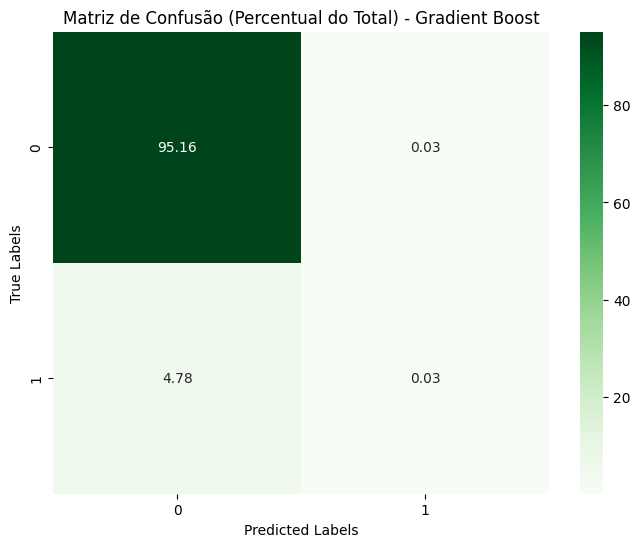

Confusion Matrix: 
 [[9639    3]
 [ 484    3]]


In [953]:
# File 4 - Gradient Boosting Imbalanced

GB4 = GradientBoostingClassifier()
GB4.fit(df_X_train_4, df_y_train_4)

y_pred_gb4 = GB4.predict(df_X_test_4)

matrix(df_y_test_4,y_pred_gb4)

# Salvando os resultados no dicionário

results_4 = results_metrics()
add_results(
    df_y_test = df_y_test_4,
    df_y_pred = y_pred_gb4, 
    label = 'Imbalanced', 
    df = results_4
)

*File 5*

C:\Users\arau012\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Gradient Boost - Resultados


Relatório de Classificação

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      9214
           1       0.67      0.01      0.02       368

    accuracy                           0.96      9582
   macro avg       0.81      0.51      0.50      9582
weighted avg       0.95      0.96      0.94      9582


Matriz de Confusão



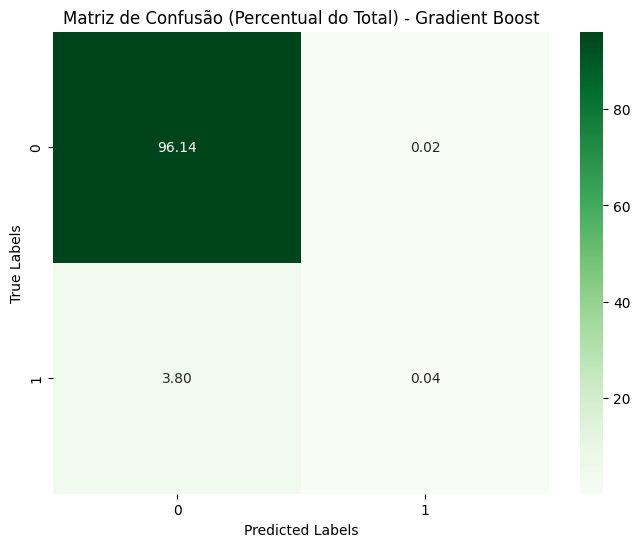

Confusion Matrix: 
 [[9212    2]
 [ 364    4]]


In [954]:
# File 5 - Gradient Boosting Imbalanced

GB5 = GradientBoostingClassifier()
GB5.fit(df_X_train_5, df_y_train_5)

y_pred_gb5 = GB5.predict(df_X_test_5)

matrix(df_y_test_5,y_pred_gb5) 

# Salvando os resultados no dicionário

results_5 = results_metrics()
add_results(
    df_y_test = df_y_test_5,
    df_y_pred = y_pred_gb5, 
    label = 'Imbalanced', 
    df = results_5
)

## Building Models - Threshold-Moving

*Metrics + Threshold Method*

In [955]:
def metrics (df_y_true,y_pred):
    accuracy_original = round(accuracy_score(df_y_true, y_pred), 4)
    precision_original = round(precision_score(df_y_true, y_pred), 4)
    recall_original = round(recall_score(df_y_true, y_pred), 4)
    F1_score_original = round(f1_score(df_y_true, y_pred), 4)
    metrics_original = [accuracy_original, precision_original, recall_original, F1_score_original]
    return metrics_original

In [956]:
def threshold (GB,df_X_val,df_y_val,y_pred):
    cols = ['Metrics', 'Original']
    adj_threshold = pd.DataFrame()
    adj_threshold['Original'] = metrics(df_y_val,y_pred)

    thresholds = [ j/20 for j in range(1,16)]
    for i in thresholds:

        y_pred_new_threshold = (GB.predict_proba(df_X_val)[:,1]>=i).astype(int) #calculating the threshold with respect to class 1

        accuracy_adj_threshold =  round(accuracy_score(df_y_val, y_pred_new_threshold), 4)
        precision_adj_threshold =  round(precision_score(df_y_val, y_pred_new_threshold, average='binary'), 4)
        recall_adj_threshold = round(recall_score(df_y_val, y_pred_new_threshold, average='binary'), 4)
        F1_score_adj_threshold =  round((f1_score(df_y_val, y_pred_new_threshold, average='binary')), 4)
        metrics_adj_threshold = [accuracy_adj_threshold, precision_adj_threshold, recall_adj_threshold, F1_score_adj_threshold]
        name = 'Threshold: ' + str(i) 
        adj_threshold[name] = metrics_adj_threshold
        cols.append(name)


    adj_threshold.index = ['Accuracy','Precision', 'Recall', 'F1_score']
    adj_threshold = adj_threshold.reset_index()
    adj_threshold.columns = cols
    adj_threshold.transpose()

    adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
    adj_threshold1.columns = adj_threshold.iloc[:,0]
    return adj_threshold1

*File 1*

In [957]:
# File 1 - Gradient Boosting Imbalanced

GB1 = GradientBoostingClassifier()
GB1.fit(df_X_train_1, df_y_train_1)

y_pred_val_1 = GB1.predict(df_X_val_1)

C:\Users\arau012\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [958]:
# File 1 - Threshold-Moving

threshold_1 = threshold(GB1, df_X_val_1, df_y_val_1, y_pred_val_1)
threshold_1

Metrics,Accuracy,Precision,Recall,F1_score
Original,0.9657,0.5,0.0227,0.0435
Threshold: 0.05,0.9084,0.0491,0.0909,0.0637
Threshold: 0.1,0.9474,0.1017,0.0682,0.0816
Threshold: 0.15,0.9591,0.1852,0.0568,0.087
Threshold: 0.2,0.9595,0.1667,0.0455,0.0714
Threshold: 0.25,0.9598,0.1739,0.0455,0.0721
Threshold: 0.3,0.9645,0.3333,0.0341,0.0619
Threshold: 0.35,0.9657,0.5,0.0227,0.0435
Threshold: 0.4,0.9657,0.5,0.0227,0.0435
Threshold: 0.45,0.9657,0.5,0.0227,0.0435


In [959]:
# File 1 - Comparing results

index_1 = threshold_1['F1_score'].idxmax()
f1_best_1 = threshold_1.loc[[index_1]]
print(f1_best_1)

Metrics         Accuracy Precision  Recall F1_score
Threshold: 0.15   0.9591    0.1852  0.0568    0.087


In [960]:
# File 1 - Salvando os resultados no dicionário

th_1 = 0.15
y_pred_new_threshold_1 = (GB1.predict_proba(df_X_test_1)[:,1]>=th_1).astype(int)

add_results(
    df_y_test = df_y_test_1,
    df_y_pred = y_pred_new_threshold_1, 
    label = 'Threshold' + str(th_1), 
    df = results_1
)

Confusion Matrix: 
 [[692  28]
 [ 41   4]]


*File 2*

In [961]:
# File 2 - Gradient Boosting Imbalanced

GB2 = GradientBoostingClassifier()
GB2.fit(df_X_train_2, df_y_train_2)

y_pred_val_2 = GB2.predict(df_X_val_2)

C:\Users\arau012\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [962]:
# File 2 - Threshold-Moving

threshold_2 = threshold(GB2, df_X_val_2, df_y_val_2, y_pred_val_2)
threshold_2

Metrics,Accuracy,Precision,Recall,F1_score
Original,0.9662,0.25,0.0125,0.0238
Threshold: 0.05,0.96,0.0952,0.025,0.0396
Threshold: 0.1,0.9654,0.1667,0.0125,0.0233
Threshold: 0.15,0.9654,0.1667,0.0125,0.0233
Threshold: 0.2,0.9662,0.25,0.0125,0.0238
Threshold: 0.25,0.9662,0.25,0.0125,0.0238
Threshold: 0.3,0.9662,0.25,0.0125,0.0238
Threshold: 0.35,0.9662,0.25,0.0125,0.0238
Threshold: 0.4,0.9662,0.25,0.0125,0.0238
Threshold: 0.45,0.9662,0.25,0.0125,0.0238


In [963]:
# File 2 - Comparing results

index_2 = threshold_2['F1_score'].idxmax()
f1_best_2 = threshold_2.loc[[index_2]]
print(f1_best_2)

Metrics         Accuracy Precision Recall F1_score
Threshold: 0.05     0.96    0.0952  0.025   0.0396


In [964]:
# File 2 - Salvando os resultados no dicionário

th_2 = 0.05
y_pred_new_threshold_2 = (GB2.predict_proba(df_X_test_2)[:,1]>=th_2).astype(int)

add_results(
    df_y_test = df_y_test_2,
    df_y_pred = y_pred_new_threshold_2, 
    label = 'Threshold ' + str(th_2), 
    df = results_2
)

Confusion Matrix: 
 [[9696    3]
 [ 379    2]]


*File 3*

In [965]:
# File 3 - Gradient Boosting Imbalanced

GB3 = GradientBoostingClassifier()
GB3.fit(df_X_train_3, df_y_train_3)

y_pred_val_3 = GB3.predict(df_X_val_3)

C:\Users\arau012\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [966]:
# File 3 - Threshold-Moving

threshold_3 = threshold(GB3, df_X_val_3, df_y_val_3, y_pred_val_3)
threshold_3

Metrics,Accuracy,Precision,Recall,F1_score
Original,0.9485,0.16,0.0988,0.1221
Threshold: 0.05,0.911,0.1169,0.2222,0.1532
Threshold: 0.1,0.9432,0.2125,0.2099,0.2112
Threshold: 0.15,0.9427,0.2025,0.1975,0.2
Threshold: 0.2,0.9432,0.2051,0.1975,0.2013
Threshold: 0.25,0.9432,0.1974,0.1852,0.1911
Threshold: 0.3,0.9432,0.1974,0.1852,0.1911
Threshold: 0.35,0.949,0.1765,0.1111,0.1364
Threshold: 0.4,0.949,0.1765,0.1111,0.1364
Threshold: 0.45,0.949,0.1765,0.1111,0.1364


In [967]:
# File 3 - Comparing results

index_3 = threshold_3['F1_score'].idxmax()
f1_best_3 = threshold_3.loc[[index_3]]
print(f1_best_3)

Metrics        Accuracy Precision  Recall F1_score
Threshold: 0.1   0.9432    0.2125  0.2099   0.2112


In [968]:
# File 3 - Salvando os resultados no dicionário

th_3 = 0.01
y_pred_new_threshold_3 = (GB3.predict_proba(df_X_test_3)[:,1]>=th_3).astype(int)

add_results(
    df_y_test = df_y_test_3,
    df_y_pred = y_pred_new_threshold_3, 
    label = 'Threshold ' + str(th_3), 
    df = results_3
)

Confusion Matrix: 
 [[ 754 9095]
 [  75  278]]


*File 4*

In [969]:
# File 4 - Gradient Boosting Imbalanced

GB4 = GradientBoostingClassifier()
GB4.fit(df_X_train_4, df_y_train_4)

y_pred_val_4 = GB4.predict(df_X_val_4)

C:\Users\arau012\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [970]:
# File 4 - Threshold-Moving

threshold_4 = threshold(GB4, df_X_val_4, df_y_val_4, y_pred_val_4)
threshold_4

Metrics,Accuracy,Precision,Recall,F1_score
Original,0.9519,0.3333,0.0175,0.0333
Threshold: 0.05,0.8641,0.0388,0.0789,0.052
Threshold: 0.1,0.9519,0.3333,0.0175,0.0333
Threshold: 0.15,0.9519,0.3333,0.0175,0.0333
Threshold: 0.2,0.9519,0.3333,0.0175,0.0333
Threshold: 0.25,0.9519,0.3333,0.0175,0.0333
Threshold: 0.3,0.9519,0.3333,0.0175,0.0333
Threshold: 0.35,0.9519,0.3333,0.0175,0.0333
Threshold: 0.4,0.9519,0.3333,0.0175,0.0333
Threshold: 0.45,0.9519,0.3333,0.0175,0.0333


In [971]:
# File 4 - Comparing results

index_4 = threshold_4['F1_score'].idxmax()
f1_best_4 = threshold_4.loc[[index_4]]
print(f1_best_4)

Metrics         Accuracy Precision  Recall F1_score
Threshold: 0.05   0.8641    0.0388  0.0789    0.052


In [972]:
# File 4 - Salvando os resultados no dicionário

th_4 = 0.05
y_pred_new_threshold_4 = (GB4.predict_proba(df_X_test_4)[:,1]>=th_4).astype(int)

add_results(
    df_y_test = df_y_test_4,
    df_y_pred = y_pred_new_threshold_4, 
    label = 'Threshold ' + str(th_4), 
    df = results_4
)

Confusion Matrix: 
 [[8431 1211]
 [ 408   79]]


*File 5*

In [973]:
# File 5 - Gradient Boosting Imbalanced

GB5 = GradientBoostingClassifier()
GB5.fit(df_X_train_5, df_y_train_5)

y_pred_val_5 = GB5.predict(df_X_val_5)

C:\Users\arau012\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [974]:
# File 5 - Threshold-Moving

threshold_5 = threshold(GB5, df_X_val_5, df_y_val_5, y_pred_val_5)
threshold_5

Metrics,Accuracy,Precision,Recall,F1_score
Original,0.9617,0.75,0.0306,0.0588
Threshold: 0.05,0.9254,0.0594,0.0612,0.0603
Threshold: 0.1,0.9617,0.75,0.0306,0.0588
Threshold: 0.15,0.9617,0.75,0.0306,0.0588
Threshold: 0.2,0.9617,0.75,0.0306,0.0588
Threshold: 0.25,0.9617,0.75,0.0306,0.0588
Threshold: 0.3,0.9617,0.75,0.0306,0.0588
Threshold: 0.35,0.9617,0.75,0.0306,0.0588
Threshold: 0.4,0.9617,0.75,0.0306,0.0588
Threshold: 0.45,0.9617,0.75,0.0306,0.0588


In [975]:
# File 5 - Comparing results

index_5 = threshold_5['F1_score'].idxmax()
f1_best_5 = threshold_5.loc[[index_5]]
print(f1_best_5)

Metrics         Accuracy Precision  Recall F1_score
Threshold: 0.05   0.9254    0.0594  0.0612   0.0603


In [976]:
# File 5 - Salvando os resultados no dicionário

th_5 = 0.05
y_pred_new_threshold_5 = (GB5.predict_proba(df_X_test_5)[:,1]>=th_5).astype(int)

add_results(
    df_y_test = df_y_test_5,
    df_y_pred = y_pred_new_threshold_5, 
    label = 'Threshold ' + str(th_5), 
    df = results_5
)

Confusion Matrix: 
 [[8857  357]
 [ 339   29]]


## Building Model - Oversampling

In [977]:
from sklearn.utils import resample

def oversampling(df_X_train, df_y_train):
    train_data = df_X_train
    train_data['Response'] = df_y_train

    Response_Zero = train_data[train_data.Response==0]
    Response_One = train_data[train_data.Response==1]

    upsampled_One = resample(Response_One,
                            replace = True, # sample with replacement
                            n_samples = len(Response_Zero), # match number in majority class
                            random_state = 27) # reproducible results
    
    # Combinando maioria e a minoria unsampled
    upsampled = pd.concat([Response_Zero, upsampled_One])
    return upsampled

*File 1*

In [978]:
# File 1 - Oversampling

upsampled_1 = oversampling(df_X_train_1, df_y_train_1)

In [979]:
# File 1 - Dados antes do oversampling

df_y_train_1.value_counts()

0    9848
1     330
Name: count, dtype: int64

In [980]:
# File 1 - Dados depois do oversampling

upsampled_1['Response'].value_counts()

Response
0    9848
1    9848
Name: count, dtype: int64

In [981]:
# File 1 - Treinando o modelo

X_train_upsampled_1 = upsampled_1.drop(columns = ['Response'])
y_train_upsampled_1 = upsampled_1['Response']

GB1_upsampled = GradientBoostingClassifier()
GB1_upsampled.fit(X_train_upsampled_1,y_train_upsampled_1)

pred_upsampled_1 = GB1_upsampled.predict(df_X_test_1)


Gradient Boost - Resultados


Relatório de Classificação

              precision    recall  f1-score   support

           0       0.94      0.78      0.85       720
           1       0.06      0.24      0.10        45

    accuracy                           0.75       765
   macro avg       0.50      0.51      0.48       765
weighted avg       0.89      0.75      0.81       765


Matriz de Confusão



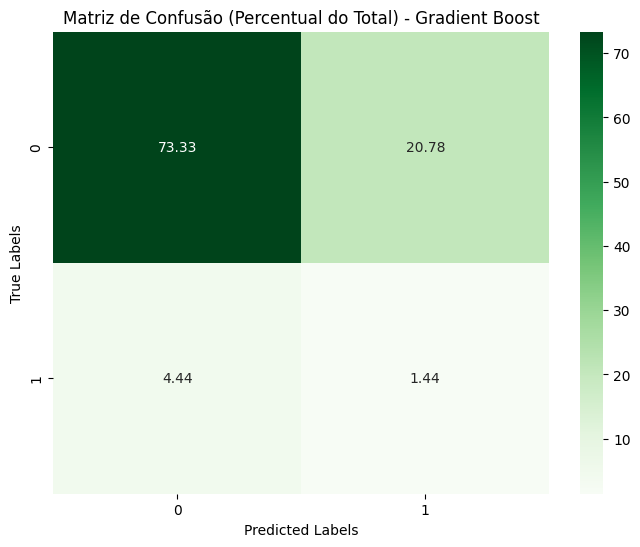

Confusion Matrix: 
 [[561 159]
 [ 34  11]]


In [982]:
# File 1 - Resultados

matrix(df_y_test_1, pred_upsampled_1)

# Salvando os resultados no dicionário

add_results(
    df_y_test = df_y_test_1,
    df_y_pred = pred_upsampled_1, 
    label = 'Oversampling', 
    df = results_1
)

*File 2*

In [983]:
# File 2 - Oversampling

upsampled_2 = oversampling(df_X_train_2, df_y_train_2)

In [984]:
# File 2 - Dados antes do oversampling

df_y_train_2.value_counts()

0    9231
1     318
Name: count, dtype: int64

In [985]:
# File 2 - Dados depois do oversampling

upsampled_2['Response'].value_counts()

Response
0    9231
1    9231
Name: count, dtype: int64

In [986]:
# File 2 - Treinando o modelo

X_train_upsampled_2 = upsampled_2.drop(columns = ['Response'])
y_train_upsampled_2 = upsampled_2['Response']

GB2_upsampled = GradientBoostingClassifier()
GB2_upsampled.fit(X_train_upsampled_2,y_train_upsampled_2)

pred_upsampled_2 = GB2_upsampled.predict(df_X_test_2)


Gradient Boost - Resultados


Relatório de Classificação

              precision    recall  f1-score   support

           0       0.96      0.88      0.92      9699
           1       0.05      0.16      0.07       381

    accuracy                           0.85     10080
   macro avg       0.51      0.52      0.50     10080
weighted avg       0.93      0.85      0.89     10080


Matriz de Confusão



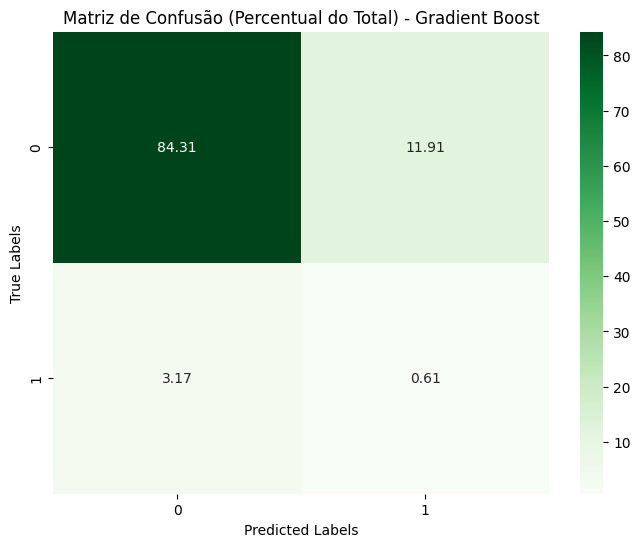

Confusion Matrix: 
 [[8498 1201]
 [ 320   61]]


In [987]:
# File 2 - Resultados

matrix(df_y_test_2, pred_upsampled_2)

# Salvando os resultados no dicionário

add_results(
    df_y_test = df_y_test_2,
    df_y_pred = pred_upsampled_2, 
    label = 'Oversampling', 
    df = results_2
)

*File 3*

In [988]:
# File 3 - Oversampling

upsampled_3 = oversampling(df_X_train_3, df_y_train_3)

In [989]:
# File 3 - Dados antes do oversampling

df_y_train_3.value_counts()

0    9344
1     338
Name: count, dtype: int64

In [990]:
# File 3 - Dados depois do oversampling

upsampled_3['Response'].value_counts()

Response
0    9344
1    9344
Name: count, dtype: int64

In [991]:
# File 3 - Treinando o modelo
X_train_upsampled_3 = upsampled_3.drop(columns = ['Response'])
y_train_upsampled_3 = upsampled_3['Response']

GB3_upsampled = GradientBoostingClassifier()
GB3_upsampled.fit(X_train_upsampled_3,y_train_upsampled_3)

pred_upsampled_3 = GB3_upsampled.predict(df_X_test_3)


Gradient Boost - Resultados


Relatório de Classificação

              precision    recall  f1-score   support

           0       0.97      0.86      0.91      9849
           1       0.05      0.23      0.09       353

    accuracy                           0.83     10202
   macro avg       0.51      0.54      0.50     10202
weighted avg       0.94      0.83      0.88     10202


Matriz de Confusão



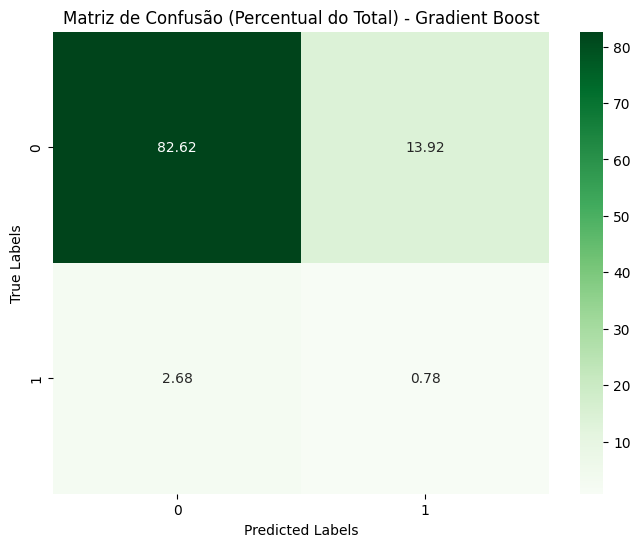

Confusion Matrix: 
 [[8429 1420]
 [ 273   80]]


In [992]:
# File 3 - Resultados

matrix(df_y_test_3, pred_upsampled_3)

# Salvando os resultados no dicionário

add_results(
    df_y_test = df_y_test_3,
    df_y_pred = pred_upsampled_3, 
    label = 'Oversampling', 
    df = results_3
)

*File 4*

In [993]:
# File 4 - Oversampling

upsampled_4 = oversampling(df_X_train_4, df_y_train_4)

In [994]:
# File 4 - Dados antes do oversampling

df_y_train_4.value_counts()

0    9787
1     432
Name: count, dtype: int64

In [995]:
# File 4 - Dados depois do oversampling

upsampled_4['Response'].value_counts()

Response
0    9787
1    9787
Name: count, dtype: int64

In [996]:
# File 4 - Treinando o modelo

X_train_upsampled_4 = upsampled_4.drop(columns = ['Response'])
y_train_upsampled_4 = upsampled_4['Response']

GB4_upsampled = GradientBoostingClassifier()
GB4_upsampled.fit(X_train_upsampled_4,y_train_upsampled_4)

pred_upsampled_4 = GB4_upsampled.predict(df_X_test_4)


Gradient Boost - Resultados


Relatório de Classificação

              precision    recall  f1-score   support

           0       0.95      0.87      0.91      9642
           1       0.06      0.16      0.09       487

    accuracy                           0.84     10129
   macro avg       0.51      0.52      0.50     10129
weighted avg       0.91      0.84      0.87     10129


Matriz de Confusão



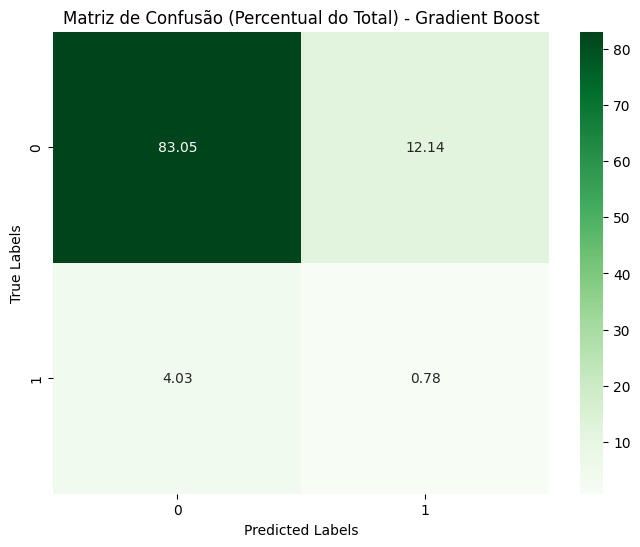

Confusion Matrix: 
 [[8412 1230]
 [ 408   79]]


In [997]:
# File 4 - Resultados

matrix(df_y_test_4, pred_upsampled_4)

# Salvando os resultados no dicionário

add_results(
    df_y_test = df_y_test_4,
    df_y_pred = pred_upsampled_4, 
    label = 'Oversampling', 
    df = results_4
)

*File 5*

In [998]:
# File 5 - Oversampling

upsampled_5 = oversampling(df_X_train_5, df_y_train_5)

In [999]:
# File 5 - Dados antes do oversampling

df_y_train_5.value_counts()

0    9666
1     346
Name: count, dtype: int64

In [1000]:
# File 5 - Dados depois do oversampling

upsampled_5['Response'].value_counts()

Response
0    9666
1    9666
Name: count, dtype: int64

In [1001]:
# File 5 - Treinando o modelo

X_train_upsampled_5 = upsampled_5.drop(columns = ['Response'])
y_train_upsampled_5 = upsampled_5['Response']

GB5_upsampled = GradientBoostingClassifier()
GB5_upsampled.fit(X_train_upsampled_5,y_train_upsampled_5)

pred_upsampled_5 = GB5_upsampled.predict(df_X_test_5)


Gradient Boost - Resultados


Relatório de Classificação

              precision    recall  f1-score   support

           0       0.96      0.88      0.92      9214
           1       0.05      0.17      0.08       368

    accuracy                           0.85      9582
   macro avg       0.51      0.53      0.50      9582
weighted avg       0.93      0.85      0.89      9582


Matriz de Confusão



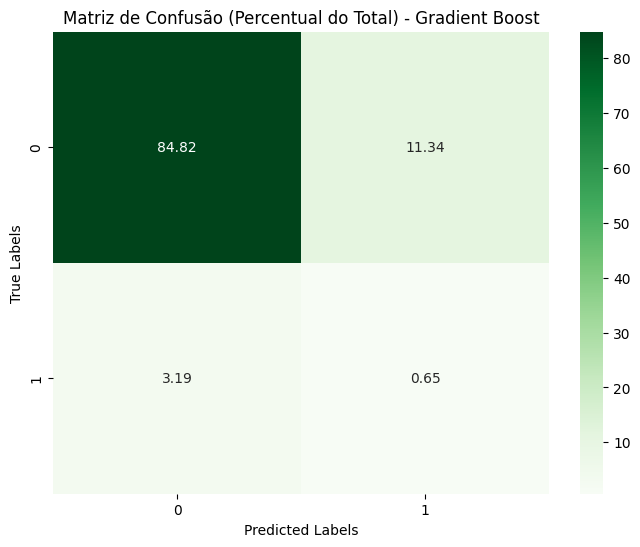

Confusion Matrix: 
 [[8127 1087]
 [ 306   62]]


In [1002]:
# File 5 - Resultados

matrix(df_y_test_5, pred_upsampled_5)

# Salvando os resultados no dicionário

add_results(
    df_y_test = df_y_test_5,
    df_y_pred = pred_upsampled_5, 
    label = 'Oversampling', 
    df = results_5
)

## Building Model - Undersampling

In [1003]:
from sklearn.utils import resample

# Undersampling

def undersampling(df_X_train, df_y_train):
    train_data = df_X_train
    train_data['Response'] = df_y_train

    Response_Zero = train_data[train_data.Response==0]
    Response_One = train_data[train_data.Response==1]

    downsampled_Zero = resample(Response_Zero,
                                    replace = False, # sample without replacement
                                    n_samples = len(Response_One), # match minority n
                                    random_state = 27) # reproducible results

    #combine minority and downsampled majority
    downsampled = pd.concat([downsampled_Zero, Response_One])
    return downsampled

*File 1*

In [1004]:
# File 1 - Undersampling

undersampled_1 = undersampling(df_X_train_1, df_y_train_1)

In [1005]:
# File 1 - Dados antes do undersampling

df_y_train_1.value_counts()

0    9848
1     330
Name: count, dtype: int64

In [1006]:
# File 1 - Dados depois do undersampling

undersampled_1['Response'].value_counts()

Response
0    330
1    330
Name: count, dtype: int64

In [1007]:
# File 1 - Treinando o modelo

X_train_undersampled_1 = undersampled_1.drop(columns = ['Response'])
y_train_undersampled_1 = undersampled_1['Response']

GB1_undersampled = GradientBoostingClassifier()
GB1_undersampled.fit(X_train_undersampled_1,y_train_undersampled_1)

pred_undersampled_1 = GB1_undersampled.predict(df_X_test_1)


Gradient Boost - Resultados


Relatório de Classificação

              precision    recall  f1-score   support

           0       0.94      0.71      0.81       720
           1       0.06      0.31      0.10        45

    accuracy                           0.69       765
   macro avg       0.50      0.51      0.46       765
weighted avg       0.89      0.69      0.77       765


Matriz de Confusão



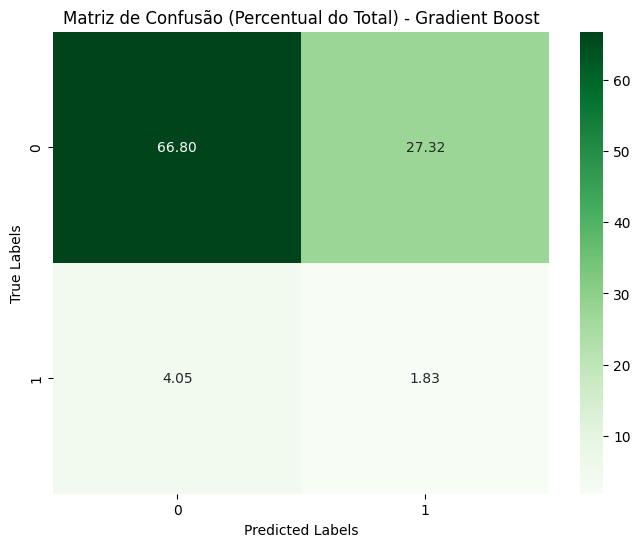

Confusion Matrix: 
 [[511 209]
 [ 31  14]]


In [1008]:
# File 1 - Resultados

matrix(df_y_test_1, pred_undersampled_1)

# Salvando os resultados no dicionário

add_results(
    df_y_test = df_y_test_1,
    df_y_pred = pred_undersampled_1, 
    label = 'Undersampling', 
    df = results_1
)

*File 2*

In [1009]:
# File 2 - Undersampling

undersampled_2 = undersampling(df_X_train_2, df_y_train_2)

In [1010]:
# File 2 - Dados antes do undersampling

df_y_train_2.value_counts()

0    9231
1     318
Name: count, dtype: int64

In [1011]:
# File 2 - Dados depois do undersampling

undersampled_2['Response'].value_counts()

Response
0    318
1    318
Name: count, dtype: int64

In [1012]:
# File 2 - Treinando o modelo

X_train_undersampled_2 = undersampled_2.drop(columns = ['Response'])
y_train_undersampled_2 = undersampled_2['Response']

GB2_undersampled = GradientBoostingClassifier()
GB2_undersampled.fit(X_train_undersampled_2,y_train_undersampled_2)

pred_undersampled_2 = GB2_undersampled.predict(df_X_test_2)


Gradient Boost - Resultados


Relatório de Classificação

              precision    recall  f1-score   support

           0       0.96      0.88      0.92      9699
           1       0.05      0.16      0.07       381

    accuracy                           0.85     10080
   macro avg       0.51      0.52      0.50     10080
weighted avg       0.93      0.85      0.89     10080


Matriz de Confusão



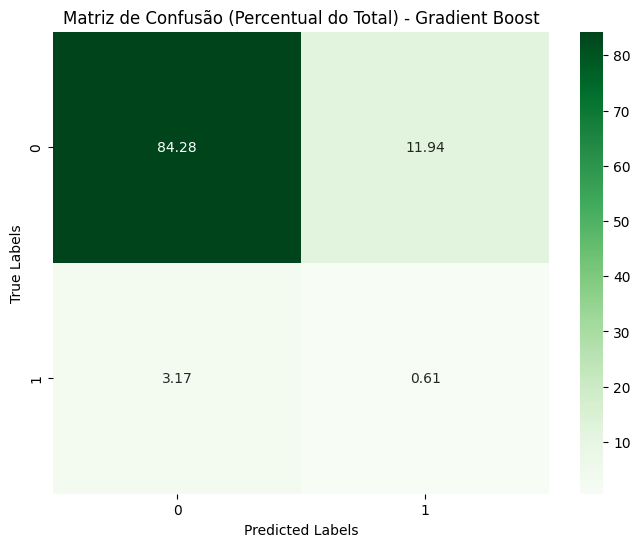

Confusion Matrix: 
 [[8495 1204]
 [ 320   61]]


In [1013]:
# File 2 - Resultados

matrix(df_y_test_2, pred_undersampled_2)

# Salvando os resultados no dicionário

add_results(
    df_y_test = df_y_test_2,
    df_y_pred = pred_undersampled_2, 
    label = 'Undersampling', 
    df = results_2
)

*File 3*

In [1014]:
# File 3 - Undersampling

undersampled_3 = undersampling(df_X_train_3, df_y_train_3)

In [1015]:
# File 3 - Dados antes do undersampling

df_y_train_3.value_counts()

0    9344
1     338
Name: count, dtype: int64

In [1016]:
# File 3 - Dados depois do undersampling

undersampled_3['Response'].value_counts()

Response
0    338
1    338
Name: count, dtype: int64

In [1017]:
# File 3 - Treinando o modelo

X_train_undersampled_3 = undersampled_3.drop(columns = ['Response'])
y_train_undersampled_3 = undersampled_3['Response']

GB3_undersampled = GradientBoostingClassifier()
GB3_undersampled.fit(X_train_undersampled_3,y_train_undersampled_3)

pred_undersampled_3 = GB3_undersampled.predict(df_X_test_3)


Gradient Boost - Resultados


Relatório de Classificação

              precision    recall  f1-score   support

           0       0.98      0.67      0.80      9849
           1       0.05      0.53      0.10       353

    accuracy                           0.67     10202
   macro avg       0.51      0.60      0.45     10202
weighted avg       0.94      0.67      0.77     10202


Matriz de Confusão



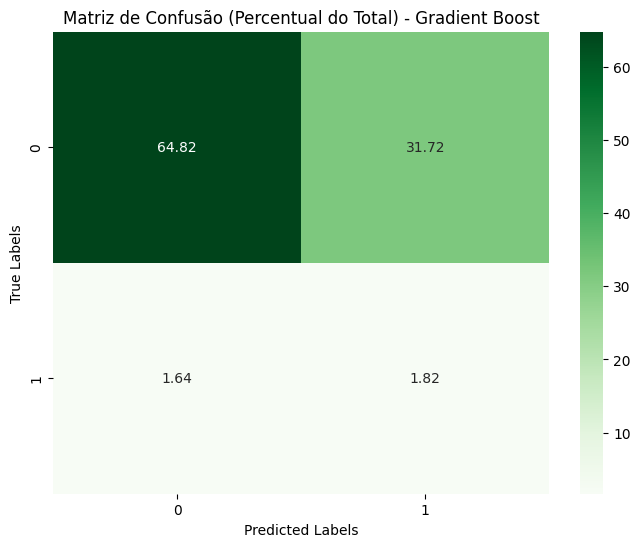

Confusion Matrix: 
 [[6613 3236]
 [ 167  186]]


In [1018]:
# File 3 - Resultados

matrix(df_y_test_3, pred_undersampled_3)

# Salvando os resultados no dicionário

add_results(
    df_y_test = df_y_test_3,
    df_y_pred = pred_undersampled_3, 
    label = 'Undersampling', 
    df = results_3
)

*File 4*

In [1019]:
# File 4 - Undersampling

undersampled_4 = undersampling(df_X_train_4, df_y_train_4)

In [1020]:
# File 4 - Dados antes do undersampling

df_y_train_4.value_counts()

0    9787
1     432
Name: count, dtype: int64

In [1021]:
# File 4 - Dados depois do undersampling

undersampled_4['Response'].value_counts()

Response
0    432
1    432
Name: count, dtype: int64

In [1022]:
# File 4 - Treinando o modelo

X_train_undersampled_4 = undersampled_4.drop(columns = ['Response'])
y_train_undersampled_4 = undersampled_4['Response']

GB4_undersampled = GradientBoostingClassifier()
GB4_undersampled.fit(X_train_undersampled_4,y_train_undersampled_4)

pred_undersampled_4 = GB4_undersampled.predict(df_X_test_4)


Gradient Boost - Resultados


Relatório de Classificação

              precision    recall  f1-score   support

           0       0.95      0.87      0.91      9642
           1       0.06      0.16      0.09       487

    accuracy                           0.84     10129
   macro avg       0.51      0.52      0.50     10129
weighted avg       0.91      0.84      0.87     10129


Matriz de Confusão



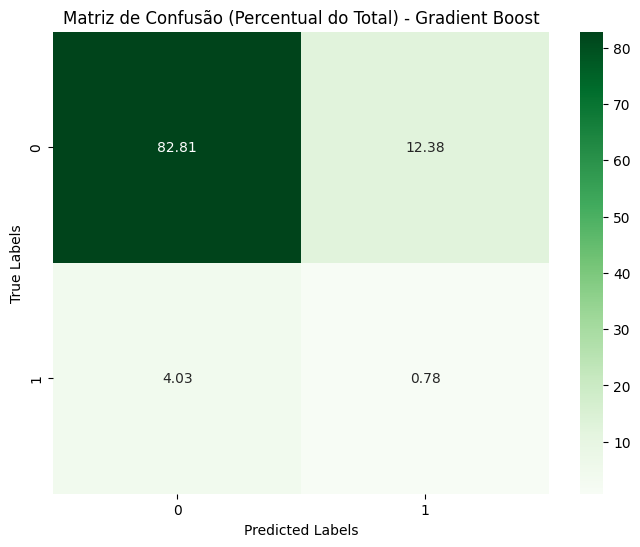

Confusion Matrix: 
 [[8388 1254]
 [ 408   79]]


In [1023]:
# File 4 - Resultados

matrix(df_y_test_4, pred_undersampled_4)

# Salvando os resultados no dicionário

add_results(
    df_y_test = df_y_test_4,
    df_y_pred = pred_undersampled_4, 
    label = 'Undersampling', 
    df = results_4
)

*File 5*

In [1024]:
# File 5 - Undersampling

undersampled_5 = undersampling(df_X_train_5, df_y_train_5)

In [1025]:
# File 5 - Dados antes do undersampling

df_y_train_5.value_counts()

0    9666
1     346
Name: count, dtype: int64

In [1027]:
# File 5 - Dados depois do undersampling

undersampled_5['Response'].value_counts()

Response
0    346
1    346
Name: count, dtype: int64

In [1028]:
# File 5 - Treinando o modelo

X_train_undersampled_5 = undersampled_5.drop(columns = ['Response'])
y_train_undersampled_5 = undersampled_5['Response']

GB5_undersampled = GradientBoostingClassifier()
GB5_undersampled.fit(X_train_undersampled_5,y_train_undersampled_5)

pred_undersampled_5 = GB2_undersampled.predict(df_X_test_5)


Gradient Boost - Resultados


Relatório de Classificação

              precision    recall  f1-score   support

           0       0.96      0.87      0.91      9214
           1       0.05      0.17      0.08       368

    accuracy                           0.84      9582
   macro avg       0.51      0.52      0.50      9582
weighted avg       0.93      0.84      0.88      9582


Matriz de Confusão



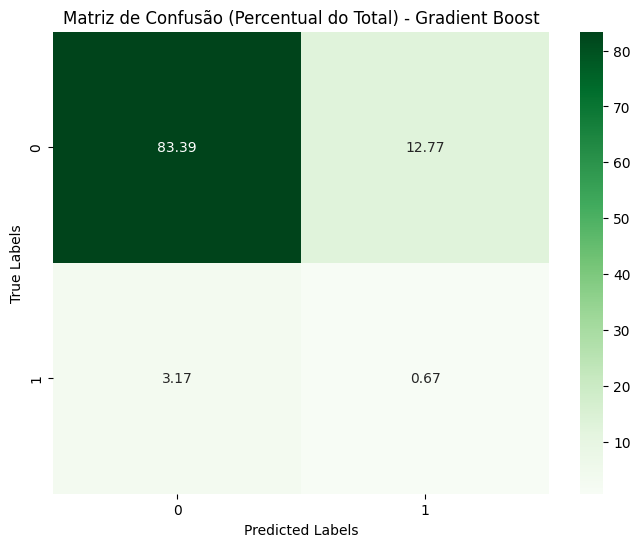

Confusion Matrix: 
 [[7990 1224]
 [ 304   64]]


In [1029]:
# File 5 - Resultados

matrix(df_y_test_5, pred_undersampled_5)

# Salvando os resultados no dicionário

add_results(
    df_y_test = df_y_test_5,
    df_y_pred = pred_undersampled_5, 
    label = 'Undersampling', 
    df = results_5
)

## Final Results

*File 1*

In [1030]:
pd.DataFrame(results_1)

,Model,Accuracy,Precision,Recall,F1_score
0,Imbalanced,0.938562,0.333333,0.044444,0.078431
1,Threshold0.15,0.909804,0.125000,0.088889,0.103896
2,Oversampling,0.747712,0.064706,0.244444,0.102326
3,Undersampling,0.686275,0.062780,0.311111,0.104478


*File 2*

In [1031]:
pd.DataFrame(results_2)

,Model,Accuracy,Precision,Recall,F1_score
0,Imbalanced,0.962202,0.500000,0.005249,0.010390
1,Threshold 0.05,0.962103,0.400000,0.005249,0.010363
2,Oversampling,0.849107,0.048336,0.160105,0.074254
3,Undersampling,0.848810,0.048221,0.160105,0.074119


*File 3*

In [1032]:
pd.DataFrame(results_3)

,Model,Accuracy,Precision,Recall,F1_score
0,Imbalanced,0.951088,0.149038,0.087819,0.110517
1,Threshold 0.01,0.101157,0.029660,0.787535,0.057166
2,Oversampling,0.834052,0.053333,0.226629,0.086346
3,Undersampling,0.666438,0.054354,0.526912,0.098543


*File 4*

In [1033]:
pd.DataFrame(results_4)

,Model,Accuracy,Precision,Recall,F1_score
0,Imbalanced,0.951920,0.500000,0.006160,0.012170
1,Threshold 0.05,0.840162,0.061240,0.162218,0.088914
2,Oversampling,0.838286,0.060351,0.162218,0.087973
3,Undersampling,0.835917,0.059265,0.162218,0.086813


*File 5*

In [1034]:
pd.DataFrame(results_5)

,Model,Accuracy,Precision,Recall,F1_score
0,Imbalanced,0.961803,0.666667,0.010870,0.021390
1,Threshold 0.05,0.927364,0.075130,0.078804,0.076923
2,Oversampling,0.854623,0.053960,0.168478,0.081740
3,Undersampling,0.840534,0.049689,0.173913,0.077295


# Questão 4 - Calibração de Modelos

## Briefing

* Considerar o arquivo A652.pickle;
* Ajustar um modelo de classificação sobre esse conjunto de dados;
* Usar novamente o algoritmo sklearn.ensemble.GradientBoostingClassifier;
* Investigar o grau de calibração do modelo resultante e, 
* Se for o caso, aplicar alguma técnica para calibrar os resultados do modelo;
* Apresentar gráficos para ilustrar os graus de calibração dos modelos antes e após a calibração;
* Apresentar uma análise dos resultados obtidos.

## Creating the DataFrame

In [826]:
# A652.pickle

a652 = open('.\data\A652.pickle', 'rb')
(X_train , y_train , X_val , y_val , X_test , y_test) = pickle.load(a652)

# Criando os DataFrames
X_train = pd.DataFrame(X_train)
y_train = pd.DataFrame(y_train)
X_val = pd.DataFrame(X_val)
y_val = pd.DataFrame(y_val)
X_test = pd.DataFrame(X_test)
y_test = pd.DataFrame(y_test)

print(f'Shapes: ', X_train.shape, X_val.shape, X_test.shape)

Shapes:  (10012, 24) (2506, 24) (9582, 24)


In [827]:
# Concatenando Treino e Val

X_train = pd.concat([X_train, X_val], axis=0)
y_train = pd.concat([y_train, y_val], axis=0)

print(f'Shapes: ', X_train.shape, X_test.shape, y_train.shape, y_test.shape)


Shapes:  (12518, 24) (9582, 24) (12518, 1) (9582, 1)


## Data Processing

*Tratando Valores de y*

In [828]:
# Transformando em binário

def transform_to_binary(df):
    return df.apply(lambda x: 1 if x > 0 else x)
    

In [829]:
# Tratando y

y_val = y_val.apply(transform_to_binary)
y_train = y_train.apply(transform_to_binary)
y_test = y_test.apply(transform_to_binary)


In [830]:
# Checando se y_train virou binário

y_train[0].value_counts()



0
0.0    11535
1.0      983
Name: count, dtype: int64

In [831]:
# Checando se y_test virou binário

y_test[0].value_counts()

0
0.0    8769
1.0     813
Name: count, dtype: int64

## Building Model - Gradient Boosting

C:\Users\arau012\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Gradient Boost - Resultados


Relatório de Classificação

              precision    recall  f1-score   support

         0.0       0.94      0.99      0.97      8769
         1.0       0.81      0.37      0.51       813

    accuracy                           0.94      9582
   macro avg       0.88      0.68      0.74      9582
weighted avg       0.93      0.94      0.93      9582


Matriz de Confusão



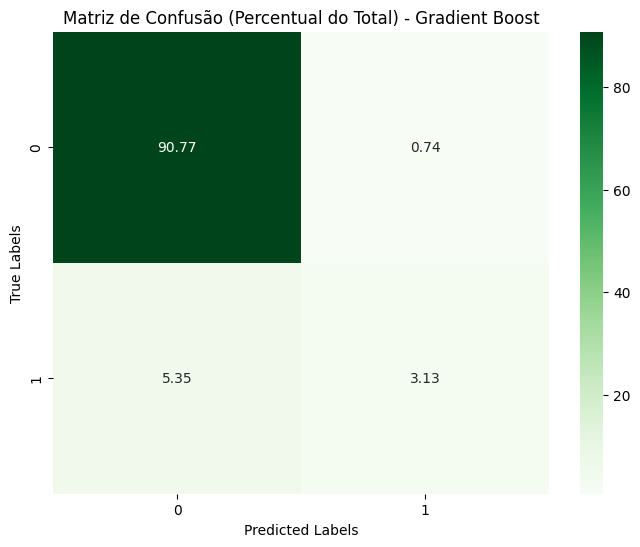

In [832]:
# Testando o modelo

GB = GradientBoostingClassifier()
GB.fit(X_train, y_train)

y_pred_gb = GB.predict(X_test)

matrix(y_test, y_pred_gb)


## Model Calibration 

Para decidir qual método de calibração usar, avaliei entre o Sigmoid e o Isotonic.
No entanto, na própria documentação do Scikit Learn, é dito que o Sigmoid não é indicado para dados altamente desbalanceados, como é o caso do dataframe que estamos trabalhando. 
"The Sigmoid method (...) can be a problem for highly imbalanced classification problems, where outputs do not have equal variance."
Disponível em: https://scikit-learn.org/stable/modules/calibration.html

Com isso, vamos usar o Isotonic.

CV = Prefit


Gradient Boost - Resultados


Relatório de Classificação

              precision    recall  f1-score   support

         0.0       0.94      0.99      0.97      8769
         1.0       0.82      0.32      0.47       813

    accuracy                           0.94      9582
   macro avg       0.88      0.66      0.72      9582
weighted avg       0.93      0.94      0.92      9582


Matriz de Confusão



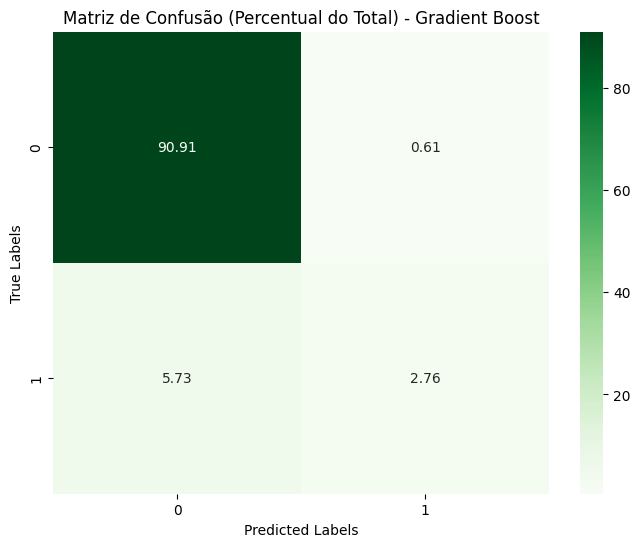

In [833]:
calibrated_GBP = CalibratedClassifierCV(GB, method='isotonic', cv='prefit')
calibrated_GBP.fit(X_train, y_train)

y_pred_calibrated_GBP = calibrated_GBP.predict(X_test)
matrix(y_test, y_pred_calibrated_GBP)

CV = 4

C:\Users\arau012\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\arau012\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\arau012\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vect


Gradient Boost - Resultados


Relatório de Classificação

              precision    recall  f1-score   support

         0.0       0.94      0.99      0.97      8769
         1.0       0.80      0.38      0.51       813

    accuracy                           0.94      9582
   macro avg       0.87      0.68      0.74      9582
weighted avg       0.93      0.94      0.93      9582


Matriz de Confusão



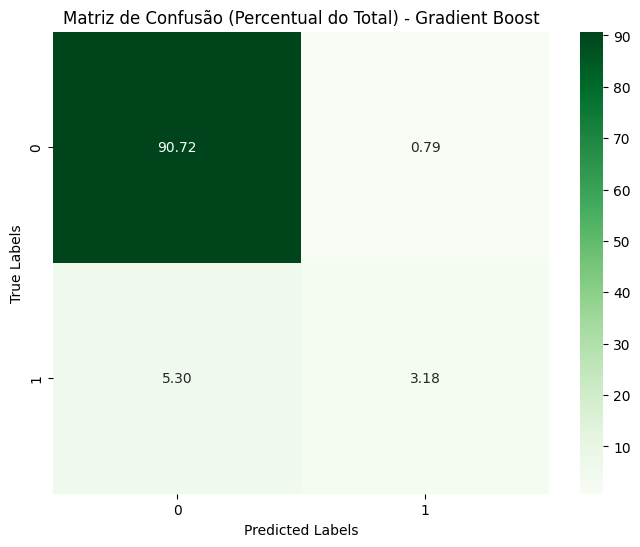

In [834]:
calibrated_GB4 = CalibratedClassifierCV(GB, method='isotonic', cv=4)
calibrated_GB4.fit(X_train, y_train)

y_pred_calibrated_GB4 = calibrated_GB4.predict(X_test)
matrix(y_test, y_pred_calibrated_GB4)

*CV = 5*

C:\Users\arau012\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\arau012\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\arau012\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vect


Gradient Boost - Resultados


Relatório de Classificação

              precision    recall  f1-score   support

         0.0       0.94      0.99      0.97      8769
         1.0       0.81      0.35      0.48       813

    accuracy                           0.94      9582
   macro avg       0.87      0.67      0.73      9582
weighted avg       0.93      0.94      0.93      9582


Matriz de Confusão



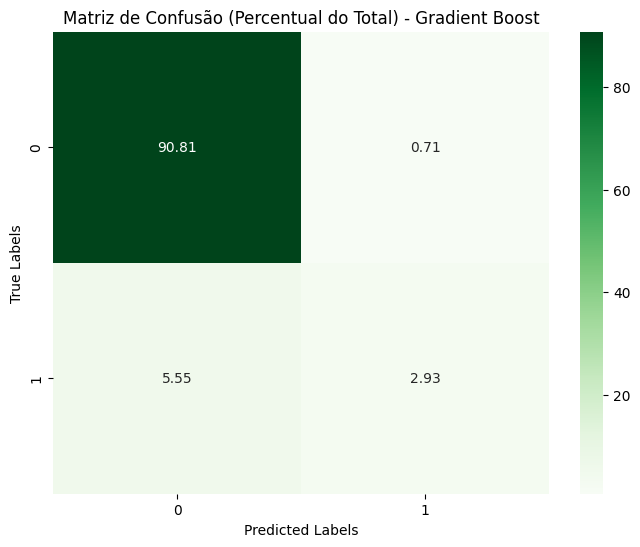

In [835]:
calibrated_GB5 = CalibratedClassifierCV(GB, method='isotonic', cv=5)
calibrated_GB5.fit(X_train, y_train)

y_pred_calibrated_GB5 = calibrated_GB5.predict(X_test)
matrix(y_test, y_pred_calibrated_GB5)

CV = 6

C:\Users\arau012\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\arau012\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\arau012\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vect


Gradient Boost - Resultados


Relatório de Classificação

              precision    recall  f1-score   support

         0.0       0.94      0.99      0.97      8769
         1.0       0.81      0.35      0.48       813

    accuracy                           0.94      9582
   macro avg       0.87      0.67      0.73      9582
weighted avg       0.93      0.94      0.93      9582


Matriz de Confusão



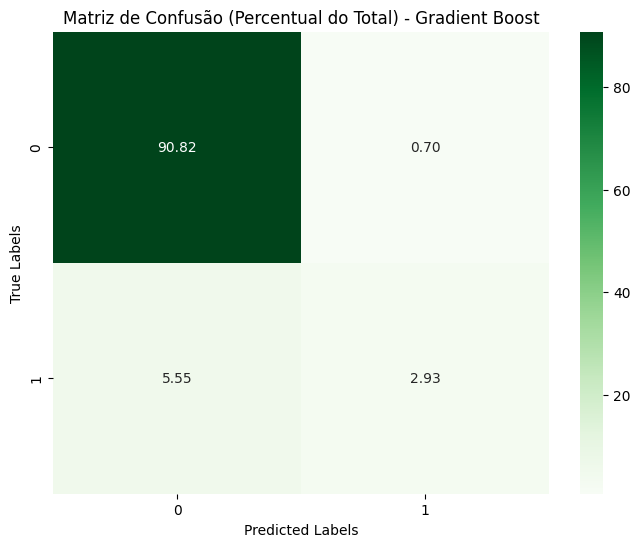

In [836]:
calibrated_GB6 = CalibratedClassifierCV(GB, method='isotonic', cv=6)
calibrated_GB6.fit(X_train, y_train)

y_pred_calibrated_GB6 = calibrated_GB6.predict(X_test)
matrix(y_test, y_pred_calibrated_GB6)

## Final Results

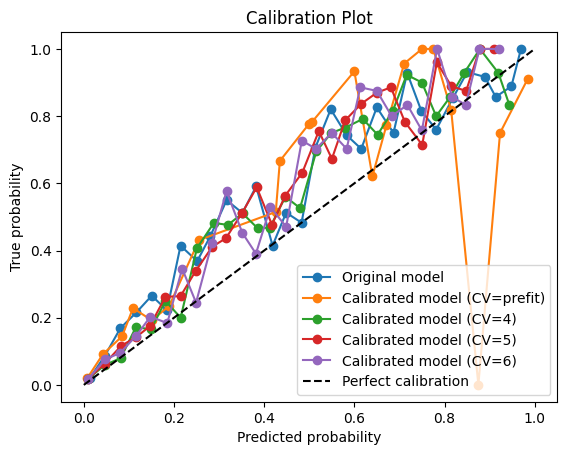

In [837]:
# probabilidades do modelo original
probs = GB.predict_proba(X_test)[:, 1]

# Probabilidades do modelo calibrado
probs_prefit = calibrated_GBP.predict_proba(X_test)[:, 1]
probs_4 = calibrated_GB4.predict_proba(X_test)[:, 1]
probs_5 = calibrated_GB5.predict_proba(X_test)[:, 1]
probs_6 = calibrated_GB6.predict_proba(X_test)[:, 1]

# Plotar curva de calibração do modelo original
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, probs, n_bins=30)
plt.plot(mean_predicted_value, fraction_of_positives, 'o-', label='Original model')

calibrated_fraction_of_positives, calibrated_mean_predicted_value = calibration_curve(y_test, probs_prefit, n_bins=30)
plt.plot(calibrated_mean_predicted_value, calibrated_fraction_of_positives, 'o-', label=f'Calibrated model (CV=prefit)')

calibrated_fraction_of_positives, calibrated_mean_predicted_value = calibration_curve(y_test, probs_4, n_bins=30)
plt.plot(calibrated_mean_predicted_value, calibrated_fraction_of_positives, 'o-', label=f'Calibrated model (CV=4)')

calibrated_fraction_of_positives, calibrated_mean_predicted_value = calibration_curve(y_test, probs_5, n_bins=30)
plt.plot(calibrated_mean_predicted_value, calibrated_fraction_of_positives, 'o-', label=f'Calibrated model (CV=5)')

calibrated_fraction_of_positives, calibrated_mean_predicted_value = calibration_curve(y_test, probs_6, n_bins=30)
plt.plot(calibrated_mean_predicted_value, calibrated_fraction_of_positives, 'o-', label=f'Calibrated model (CV=6)')

# Plotar linha diagonal para representar calibração perfeita
plt.plot([0, 1], [0, 1], 'k--', label='Perfect calibration')

plt.xlabel('Predicted probability')
plt.ylabel('True probability')
plt.title('Calibration Plot')
plt.legend(loc='lower right')

plt.show()

Com exceção do cv = "prefit", que no final saiu muito do esperado, os modelos calibrados se aproximaram bastante do "perfect calibration" no início e depois se afastaram um pouco, mas no geral, foram melhor que o modelo original. Vou testar o modelo original x o CV = 4, que senti estar melhor ajustado.

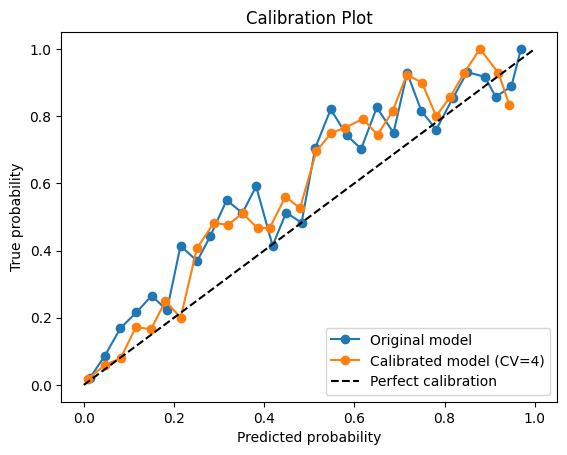

In [838]:
# probabilidades do modelo original
probs = GB.predict_proba(X_test)[:, 1]

# Probabilidades do modelo calibrado
probs_4 = calibrated_GB4.predict_proba(X_test)[:, 1]

# Plotar curva de calibração do modelo original
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, probs, n_bins=30)
plt.plot(mean_predicted_value, fraction_of_positives, 'o-', label='Original model')

calibrated_fraction_of_positives, calibrated_mean_predicted_value = calibration_curve(y_test, probs_4, n_bins=30)
plt.plot(calibrated_mean_predicted_value, calibrated_fraction_of_positives, 'o-', label=f'Calibrated model (CV=4)')

# Plotar linha diagonal para representar calibração perfeita
plt.plot([0, 1], [0, 1], 'k--', label='Perfect calibration')

plt.xlabel('Predicted probability')
plt.ylabel('True probability')
plt.title('Calibration Plot')
plt.legend(loc='lower right')

plt.show()


A calibração com CV = 4 realmente se aproximou mais do "perfect calibration".

# Questão 5 - Busca de Hiperparâmetros

## Briefing

* Usar o mesmo arquivo da questão 4;
* Escolher algum modelo da questão 1;
* Usar Grid Search ou Random Search para ajustar os hiperparâmetros.

## Creating the DataFrame

In [839]:
# A652.pickle

a652 = open('.\data\A602.pickle', 'rb')
(X_train , y_train , X_val , y_val , X_test , y_test) = pickle.load(a652)

# Criando os DataFrames
X_train = pd.DataFrame(X_train)
y_train = pd.DataFrame(y_train)
X_val = pd.DataFrame(X_val)
y_val = pd.DataFrame(y_val)
X_test = pd.DataFrame(X_test)
y_test = pd.DataFrame(y_test)

## Data Processing

In [890]:
# Concatenando Treino e Val

X_train = pd.concat([X_train, X_val], axis=0)
y_train = pd.concat([y_train, y_val], axis=0)

print(f'Shapes: ', X_train.shape, X_test.shape, y_train.shape, y_test.shape)

Shapes:  (17873, 24) (765, 24) (17873, 1) (765, 1)


In [891]:
# Transformando em binário

def transform_to_binary(df):
    return df.apply(lambda x: 1 if x > 0 else x)

In [892]:
# Tratando y

y_val = y_val.apply(transform_to_binary)
y_train = y_train.apply(transform_to_binary)
y_test = y_test.apply(transform_to_binary)


In [893]:
def results_metrics():
    return {'Model': [], 'Estimators': [], 'Depth': [], 'Split': [], 'Accuracy': [], 'Precision': [], 'Recall': [], 'F1_score': []}

In [894]:
def add_results(y_test=None, y_pred=None, label='', estimators=None, depth=None, split=None, df=None):
    df['Model'].append(label)
    df['Estimators'].append(estimators)
    df['Depth'].append(depth)
    df['Split'].append(split)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    df['Accuracy'].append(accuracy)
    df['Precision'].append(precision)
    df['Recall'].append(recall)
    df['F1_score'].append(f1)

## Building the Model - Random Forest

In [895]:
RF = RandomForestClassifier()
RF.fit(X_train, y_train)

y_pred = RF.predict(X_test)

C:\Users\arau012\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [896]:
results_RF = results_metrics()

# Random Forest
add_results(y_test = y_test,
            y_pred = y_pred, 
            label = 'Random Forest - Original',
            estimators = None,
            depth = None, 
            split = None, 
            df = results_RF)

pd.DataFrame(results_RF)

,Model,Estimators,Depth,Split,Accuracy,Precision,Recall,F1_score
0,Random Forest - Original,None,None,None,0.890196,0.551282,0.467391,0.505882


## Adjusting the Model - Hyperparameter Tuning

**GridSearch**

In [898]:
# Definindo os hiperparâmetros a serem testados
param_grid = {
    'n_estimators': [10, 50, 100, 150],        
    'max_depth': [None, 5, 10, 15],            
    'min_samples_split': [2, 5, 9]        
}

# Criar o modelo de Random Forest
rf_model = RandomForestClassifier(random_state=42)

# Criar o objeto Grid Search com cross-validation
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='accuracy')

# Treinar o modelo com Grid Search
grid_search.fit(X_train, y_train)

C:\Users\arau012\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\arau012\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\arau012\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y 

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None, 5, 10, 15],
                         'min_samples_split': [2, 5, 9],
                         'n_estimators': [10, 50, 100, 150]},
             scoring='accuracy')

In [899]:
# Encontrar os melhores hiperparâmetros
best_params_GS = grid_search.best_params_

# Encontrar o melhor modelo
best_model_GS = grid_search.best_estimator_

# Exibir os melhores hiperparâmetros
print('Melhores hiperparâmetros encontrados:\n')
print(best_params_GS)

Melhores hiperparâmetros encontrados:

{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 150}


In [900]:
y_pred_best = best_model_GS.predict(X_test)

# Random Forest
add_results(y_test = y_test,
            y_pred = y_pred_best, 
            label = 'Random Forest - GridSearch',
            estimators = 150, 
            depth = None, 
            split = 2,
            df = results_RF)

**Randomized Search**

In [901]:
from scipy.stats import randint

param_grid = {
    'n_estimators': randint(100, 200),        
    'max_depth': [None] + list(np.random.randint(5, 50, size=2)),            
    'min_samples_split': randint(2, 10)        
}

# Criar o modelo de Random Forest
rf_model = RandomForestClassifier(random_state=42)

# Criar o objeto Randomized Search com cross-validation
random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_grid, n_iter=8, cv=5, scoring='accuracy', random_state=42)

# Treinar o modelo com Randomized Search
random_search.fit(X_train, y_train)

C:\Users\arau012\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\arau012\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\arau012\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y 

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=8,
                   param_distributions={'max_depth': [None, 41, 15],
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001873C3EC3D0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000018764F481F0>},
                   random_state=42, scoring='accuracy')

In [902]:
# Encontrar os melhores hiperparâmetros
best_params_RS = random_search.best_params_

# Encontrar o melhor modelo
best_model_RS = random_search.best_estimator_

# Exibir os melhores hiperparâmetros
print('Melhores hiperparâmetros encontrados:\n')
print(best_params_RS)

Melhores hiperparâmetros encontrados:

{'max_depth': 41, 'min_samples_split': 3, 'n_estimators': 163}


In [903]:
y_pred_best = best_model_RS.predict(X_test)

# Random Forest
add_results(y_test = y_test,
            y_pred = y_pred_best, 
            label = 'Random Forest - RandomSearch',
            estimators = 163, 
            depth = 41, 
            split = 3,
            df = results_RF)

## Final Results

In [904]:
# Comparando Resultados

pd.DataFrame(results_RF)

,Model,Estimators,Depth,Split,Accuracy,Precision,Recall,F1_score
0,Random Forest - Original,NaN,NaN,NaN,0.890196,0.551282,0.467391,0.505882
1,Random Forest - GridSearch,150.0,NaN,2.0,0.890196,0.548780,0.489130,0.517241
2,Random Forest - RandomSearch,163.0,41.0,3.0,0.887582,0.535714,0.489130,0.511364
